# Analysis of the autism data

In [2]:
run init.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done.


In [3]:
df =  pd.read_csv(AUTISM_DATA_PATH)
DEFAULT_PREDICTORS = [# GAZE RELATED
                   # 'diagnosis',
                    #'mchat_total',
                     'mean_gaze_percent_right', #aggregated
                     'gaze_silhouette_score', #aggregated

                    # NAME CALL RELATED
                     'proportion_of_name_call_responses',
                     'average_response_to_name_delay',
                   #   'name_call_response_binary',


                    # POSTURAL SWAY RELATED
                     'S_postural_sway',  #aggregated
                     'NS_postural_sway',  #aggregated
                     'S_postural_sway_derivative',
                     'NS_postural_sway_derivative',

                    # TOUCH RELATED
                     'average_length',
                     'std_length',
                     'average_error',
                     'pop_rate',
                     'average_delay_to_pop',
                     'average_time_spent']

use_missing_indicator_variables = {'FunAtThePark':['FP_postural_sway', 'FP_postural_sway_derivative'],#,
                                   'RhymesAndToys': ['RT_postural_sway', 'RT_postural_sway_derivative']}
                                # 'RTNDelay':['average_response_to_name_delay']}


grouped_missing_features = {'Gaze': ['mean_gaze_percent_right', 'gaze_silhouette_score'],
                            'Social' : ['S_postural_sway', 'S_postural_sway_derivative'],
                            'Non Social' : ['NS_postural_sway', 'NS_postural_sway_derivative'],
                             #'gaze_silhouette_score': ['gaze_silhouette_score'],
                             #'proportion_of_name_call_responses': ['proportion_of_name_call_responses'],
                             'average_response_to_name_delay': ['average_response_to_name_delay'],
                             #'S_postural_sway': ['S_postural_sway'],
                             #'NS_postural_sway': ['NS_postural_sway'],
                             #'S_postural_sway': ['S_postural_sway'],
                             #'S_postural_sway_derivative': ['S_postural_sway_derivative'],
                             #'NS_postural_sway_derivative': ['NS_postural_sway_derivative'],
                             'Game': ['average_length','std_length','average_error', 'pop_rate','average_delay_to_pop','average_time_spent']}

In [11]:
df =  pd.read_csv(AUTISM_DATA_PATH)

data = Dataset(df=df, 
               missing_data_handling='without', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='diagnosis',
                features_name = DEFAULT_PREDICTORS, 
                scale_data=False,
                use_missing_indicator_variables=use_missing_indicator_variables, #use_missing_indicator_variables,#grouped_missing_features,
               verbosity=0,
               scenario=None,#'papers',
               proportion_train=1)


data.filter(administration={'studies':  ['ARC', 'P1', 'P2', 'P3'],
                                        'order': 'first',
                                        'completed': True}, 
                           demographics={'age':[17, 50]},
                            clinical={'diagnosis': [0, 1]},
                            verbose=True)

467 administrations left.


,id
diagnosis,
0.0,417
1.0,50


In [12]:
exp = Experiments(data.dataset_name,
                  dataset=data, 
                    approach='xgboost', 
                    previous_experiment=None,        
                    verbosity=1, 
                    debug=True, 
                    save_experiment=False)
    
exp.fit_predict(num_cv='loocv')

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.973,0.815,0.983,0.556,0.996,0.81,0.664,0.965,0.793,0.756,0.988,0.872,0.974,0.244,0.128,0.026


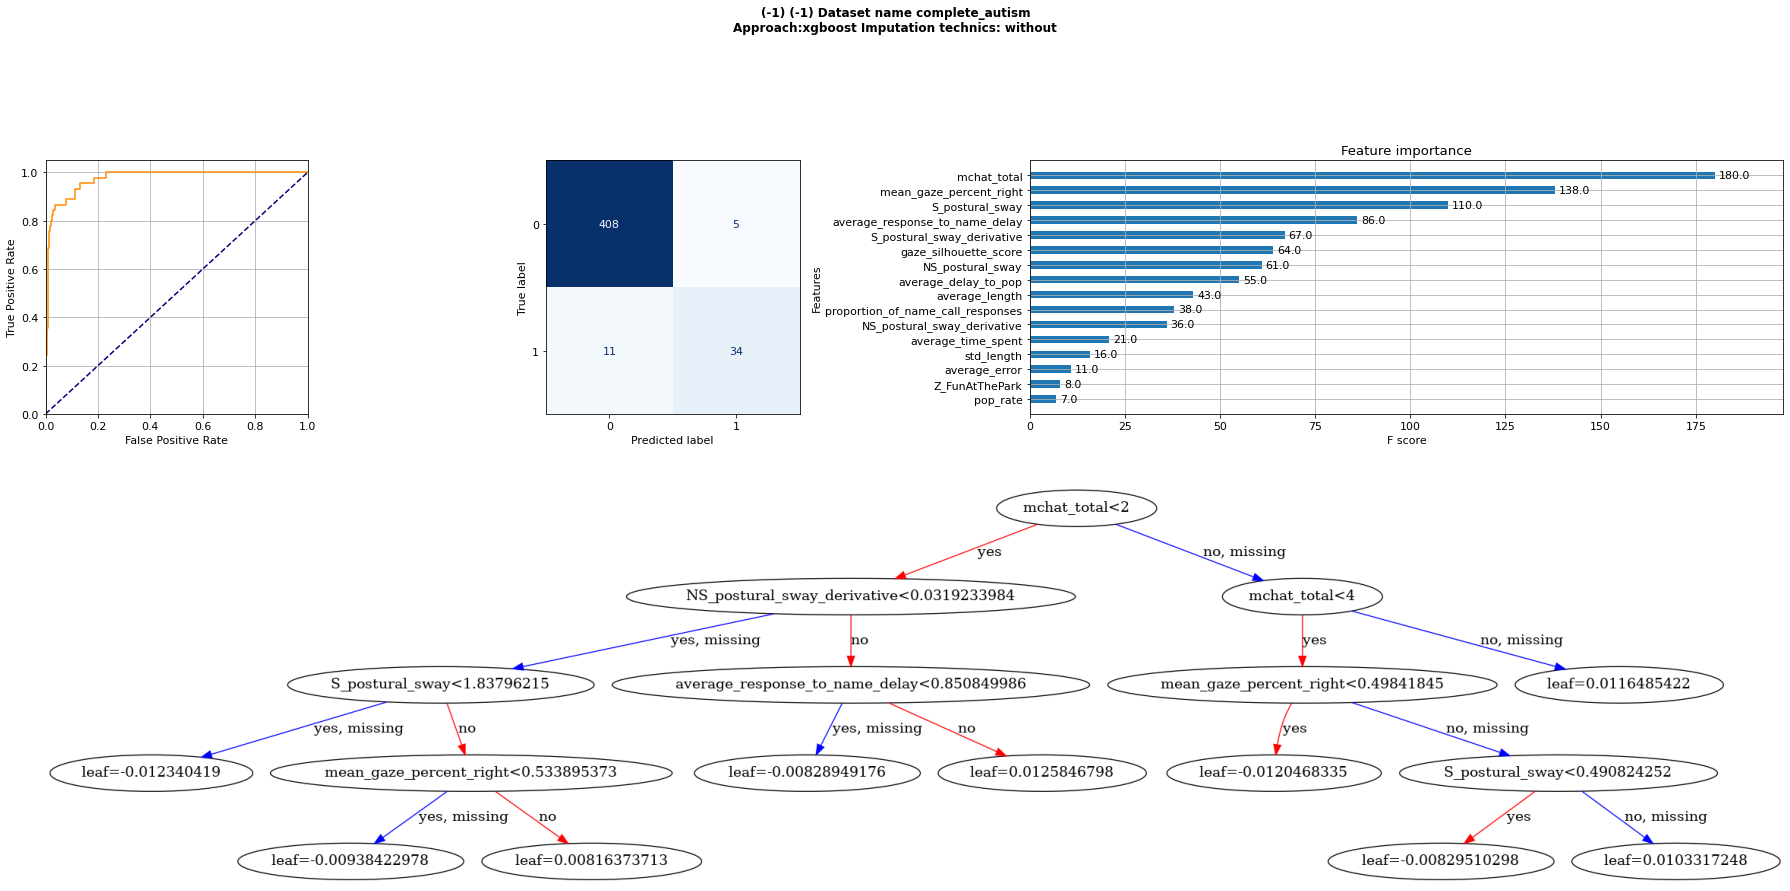

In [414]:
exp.plot()

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.873,0.43,0.872,0.187,0.967,0.482,0.217,0.841,0.443,0.756,0.85,0.354,0.97,0.244,0.646,0.03


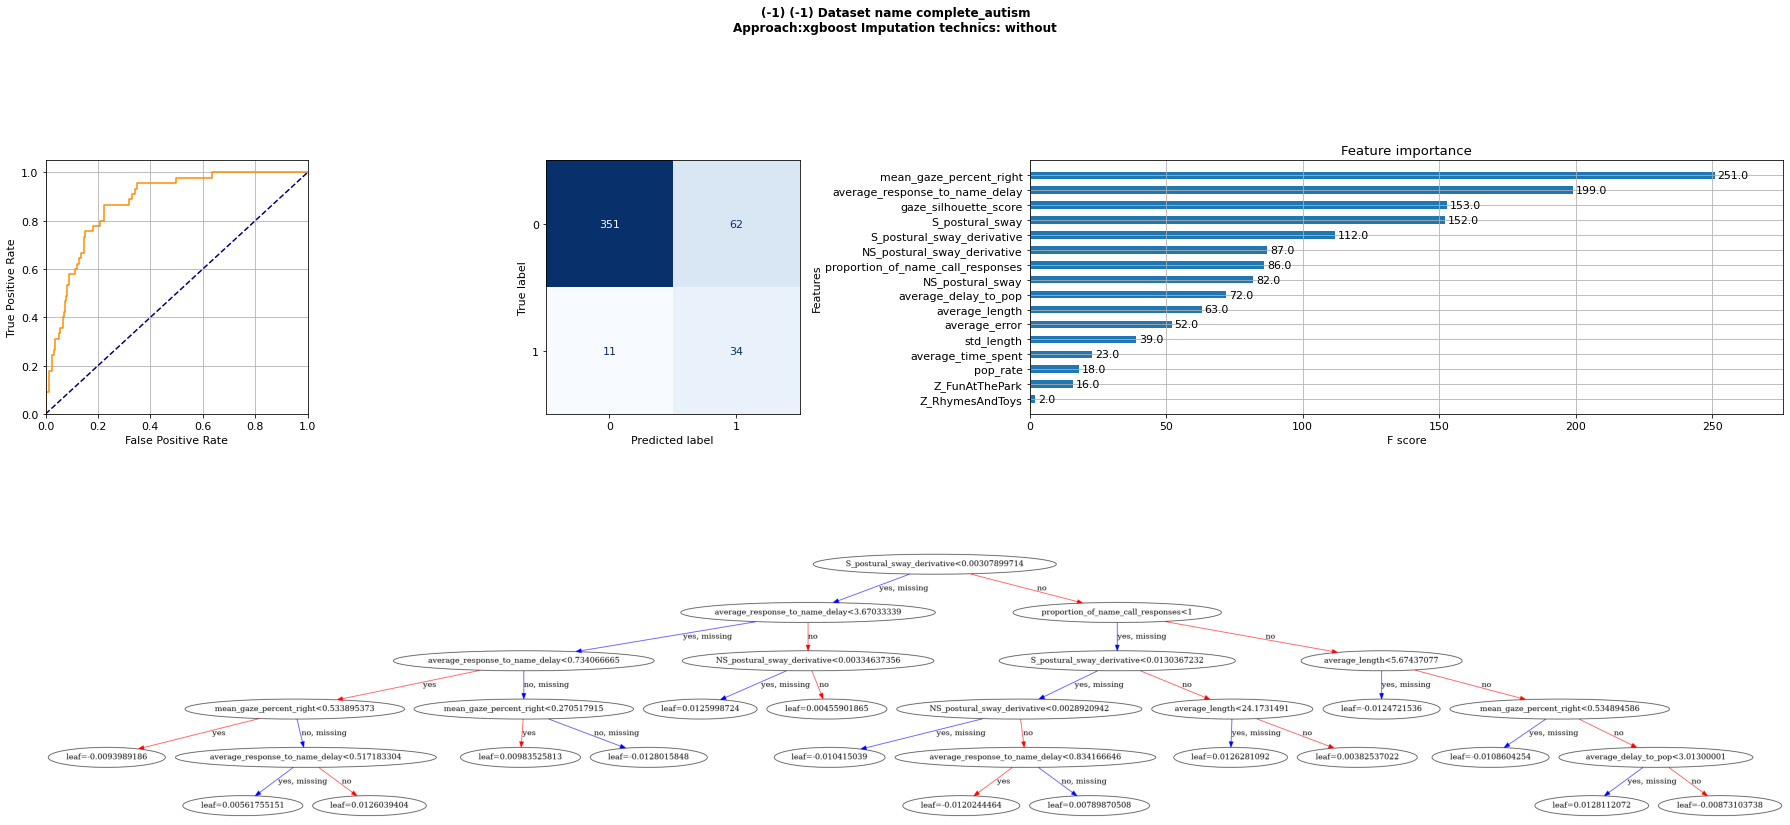

In [418]:
exp.plot()

<AxesSubplot:>

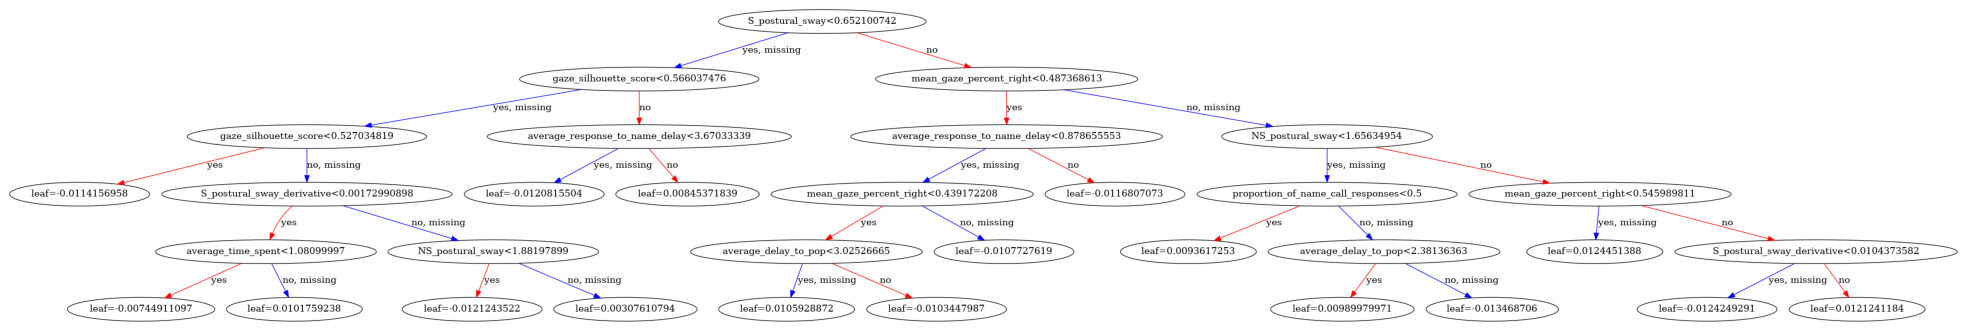

In [261]:
fi(35, 100);ax=plt.gca()
plot_tree(exp.model.get_booster(), num_trees=exp.model.best_iteration, ax=ax)

# Closer look at the Misclassified samples

In [155]:
import shap
explainer = shap.TreeExplainer(exp.model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

Explainer expected value: [0.05196995]


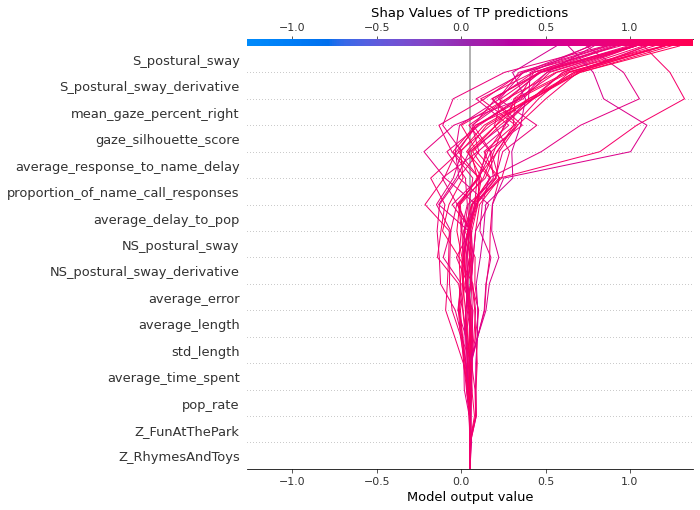

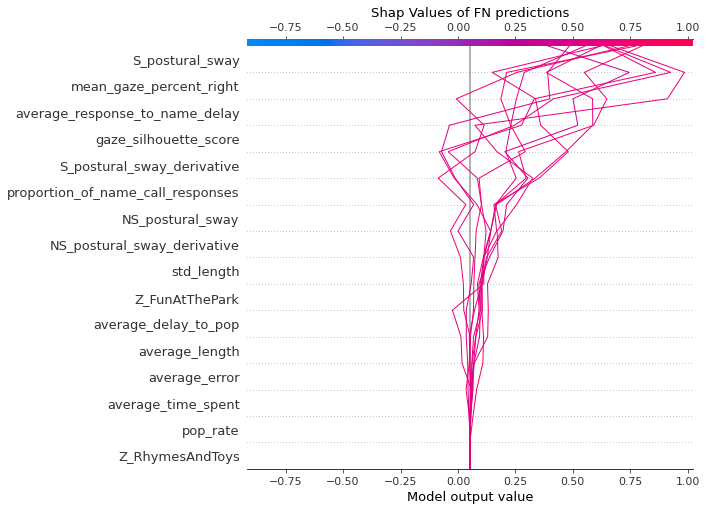

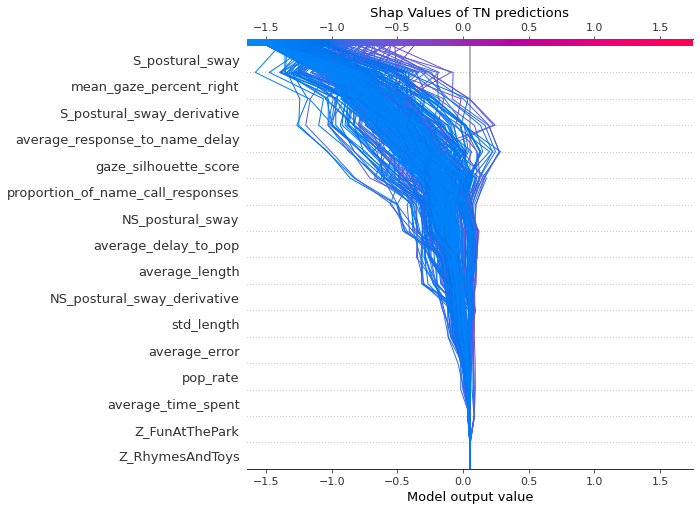

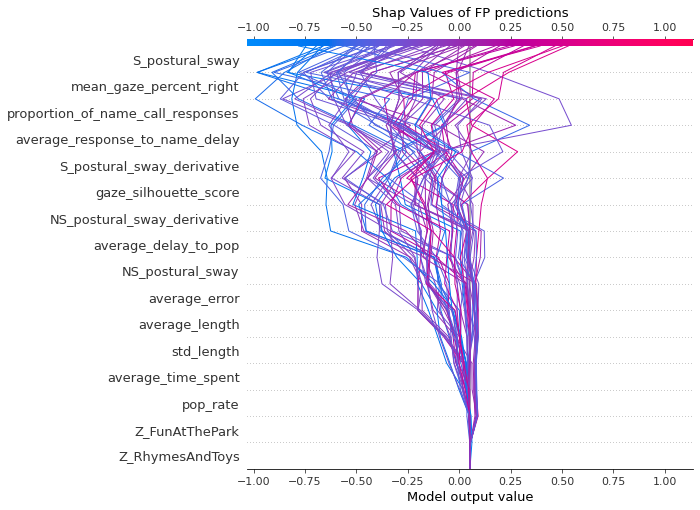

In [157]:
for name in ['TP','FN', 'TN', 'FP']:


    index  = np.array(list(exp.predictions_df[exp.predictions_df[name]==1].index))
    features = exp.predictions_df[exp.features_name]

    shap_values = explainer.shap_values(features)[index]
    shap_interaction_values = explainer.shap_interaction_values(features)
    hap_interaction_values = shap_interaction_values[index]
    shap.decision_plot(expected_value, shap_values, features, title="Shap Values of {} predictions".format(name))

In [336]:
exp.shap_values

array([[-1.98252648e-01, -2.36411303e-01,  6.30456060e-02, ...,
         2.41392714e-04, -1.04440982e-02, -8.31853016e-04],
       [-3.21265668e-01, -1.56219408e-01, -1.46824911e-01, ...,
        -1.05688181e-02, -1.05868159e-02, -8.31887126e-04],
       [ 2.14427337e-01, -2.87125081e-01,  6.46097064e-02, ...,
        -2.08437163e-03, -1.04370629e-02, -8.31921585e-04],
       ...,
       [-4.23889369e-01,  1.99949771e-01,  1.41074434e-01, ...,
        -1.09192118e-01,  3.95217352e-02,  9.19585989e-04],
       [-6.72830582e-01, -1.77458506e-02,  1.72799796e-01, ...,
        -4.72759036e-03, -2.47463724e-03,  2.12897634e-04],
       [ 2.33881876e-01, -3.78394812e-01,  5.62126227e-02, ...,
        -1.96174858e-03, -1.18234502e-02, -6.74012263e-05]])

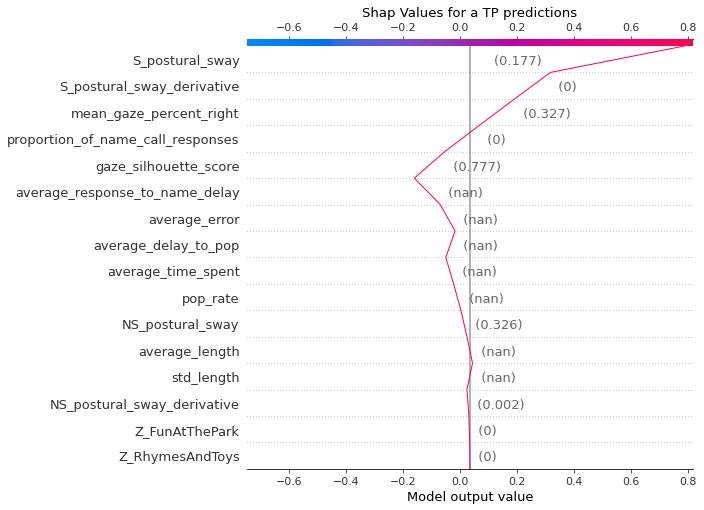

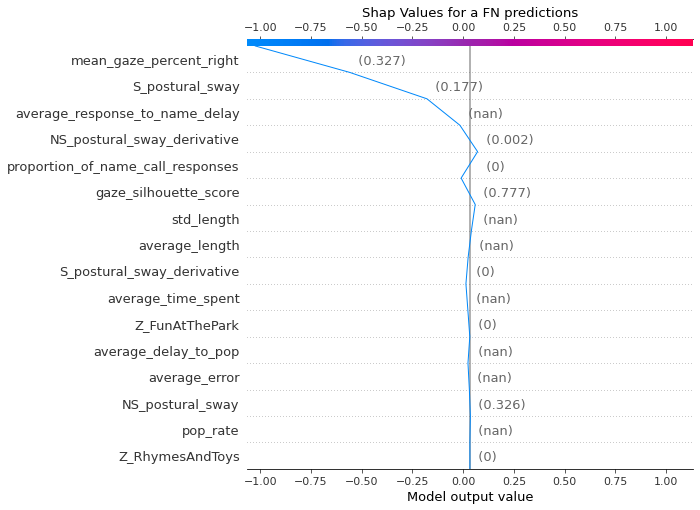

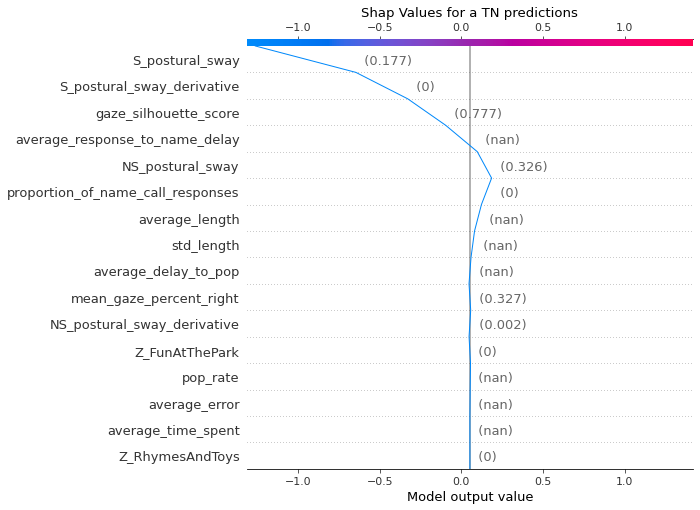

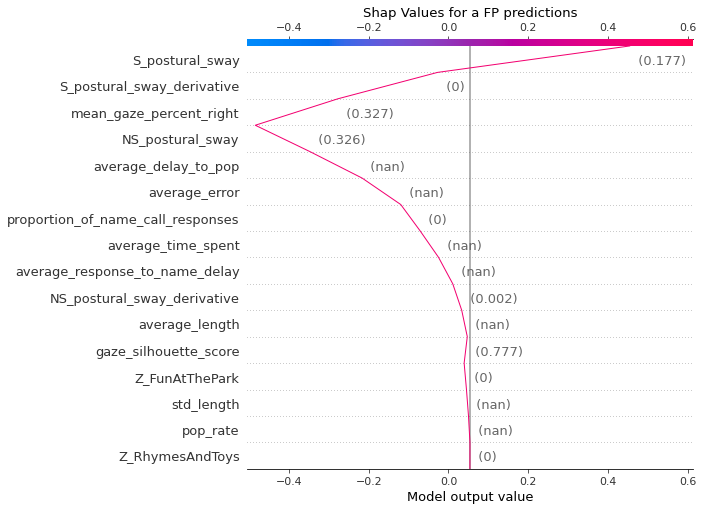

In [419]:
for name in ['TP','FN', 'TN', 'FP']:


    index  = np.array(list(exp.predictions_df[exp.predictions_df[name]==1].index))
    idx = np.random.choice(index, 1)
    features = exp.predictions_df[exp.features_name]

    shap_values = exp.shap_values[idx]
    expected_value = exp.models_expected_value[idx]

    shap.decision_plot(expected_value, shap_values, features, title="Shap Values for a {} predictions".format(name))

In [166]:
exp.predictions_df[exp.predictions_df["FP"]==1]

,mean_gaze_percent_right,gaze_silhouette_score,proportion_of_name_call_responses,average_response_to_name_delay,S_postural_sway,NS_postural_sway,S_postural_sway_derivative,NS_postural_sway_derivative,average_length,std_length,average_error,pop_rate,average_delay_to_pop,average_time_spent,Z_FunAtThePark,Z_RhymesAndToys,y_true,y_pred,TN,TP,FP,FN
3,0.434169,0.393004,1.0,0.556111,2.978287,2.007431,0.016263,0.006172,6.856880,8.420087,11.981659,0.888889,3.211286,0.927000,0.0,0.0,0.0,0.395438,0,0,1,0
14,0.582219,0.394149,1.0,1.084417,1.571709,2.184546,0.008108,0.014957,2.046430,4.182066,6.934383,1.000000,3.039333,0.394667,0.0,0.0,0.0,0.529841,0,0,1,0
17,NaN,NaN,1.0,0.350350,NaN,7.867152,NaN,0.031657,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.481251,0,0,1,0
19,NaN,NaN,0.0,NaN,NaN,0.557049,NaN,0.004827,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.599559,0,0,1,0
24,0.463798,0.538796,0.0,NaN,2.055850,2.765198,0.010665,0.014126,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.555500,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,0.527569,0.512156,1.0,0.934267,1.818750,1.548133,0.010547,0.015513,18.912710,21.276266,17.545812,0.741935,2.419182,1.158000,0.0,0.0,0.0,0.495880,0,0,1,0
422,0.356238,0.412417,0.0,NaN,3.082027,3.514687,0.015323,0.019551,27.808929,20.488259,31.386679,0.200000,3.120000,2.244500,0.0,0.0,0.0,0.726115,0,0,1,0
425,0.364255,0.561709,0.0,NaN,1.290303,0.255121,0.006714,0.000680,16.990994,30.566843,31.229982,0.142857,4.527500,3.400000,0.0,0.0,0.0,0.468757,0,0,1,0
431,0.580025,0.423957,0.0,0.166833,1.592874,3.040254,0.010235,0.030680,10.427247,7.424892,20.918809,0.486486,2.818556,0.937455,0.0,0.0,0.0,0.592347,0,0,1,0


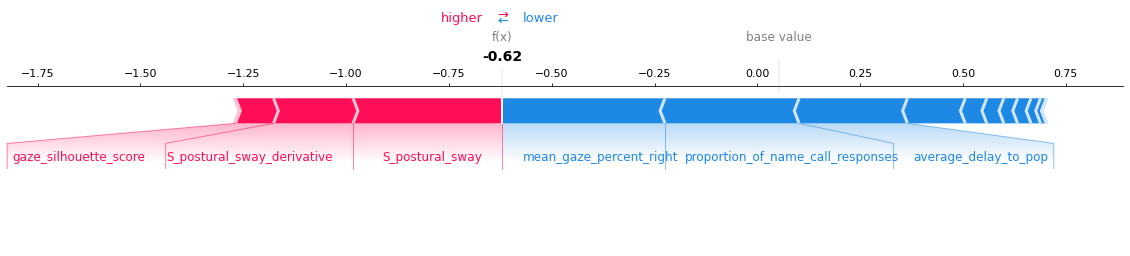

In [420]:
index  = np.array(list(exp.predictions_df[exp.predictions_df[name]==1].index))
idx = np.random.choice(index, 1)
features = exp.predictions_df[exp.features_name]

shap_values = explainer.shap_values(features)[idx]
expected_value = exp.models_expected_value[idx]
    
index  = np.array(list(exp.predictions_df[exp.predictions_df["FP"]==1].index))
features = exp.predictions_df[exp.features_name]

shap_values = explainer.shap_values(features)[index[0]]
shap.force_plot(expected_value, shap_values, feature_names=exp.features_name, matplotlib=True)

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.873,0.436,0.883,0.194,0.972,0.489,0.214,0.845,0.45,0.756,0.855,0.362,0.97,0.244,0.638,0.03


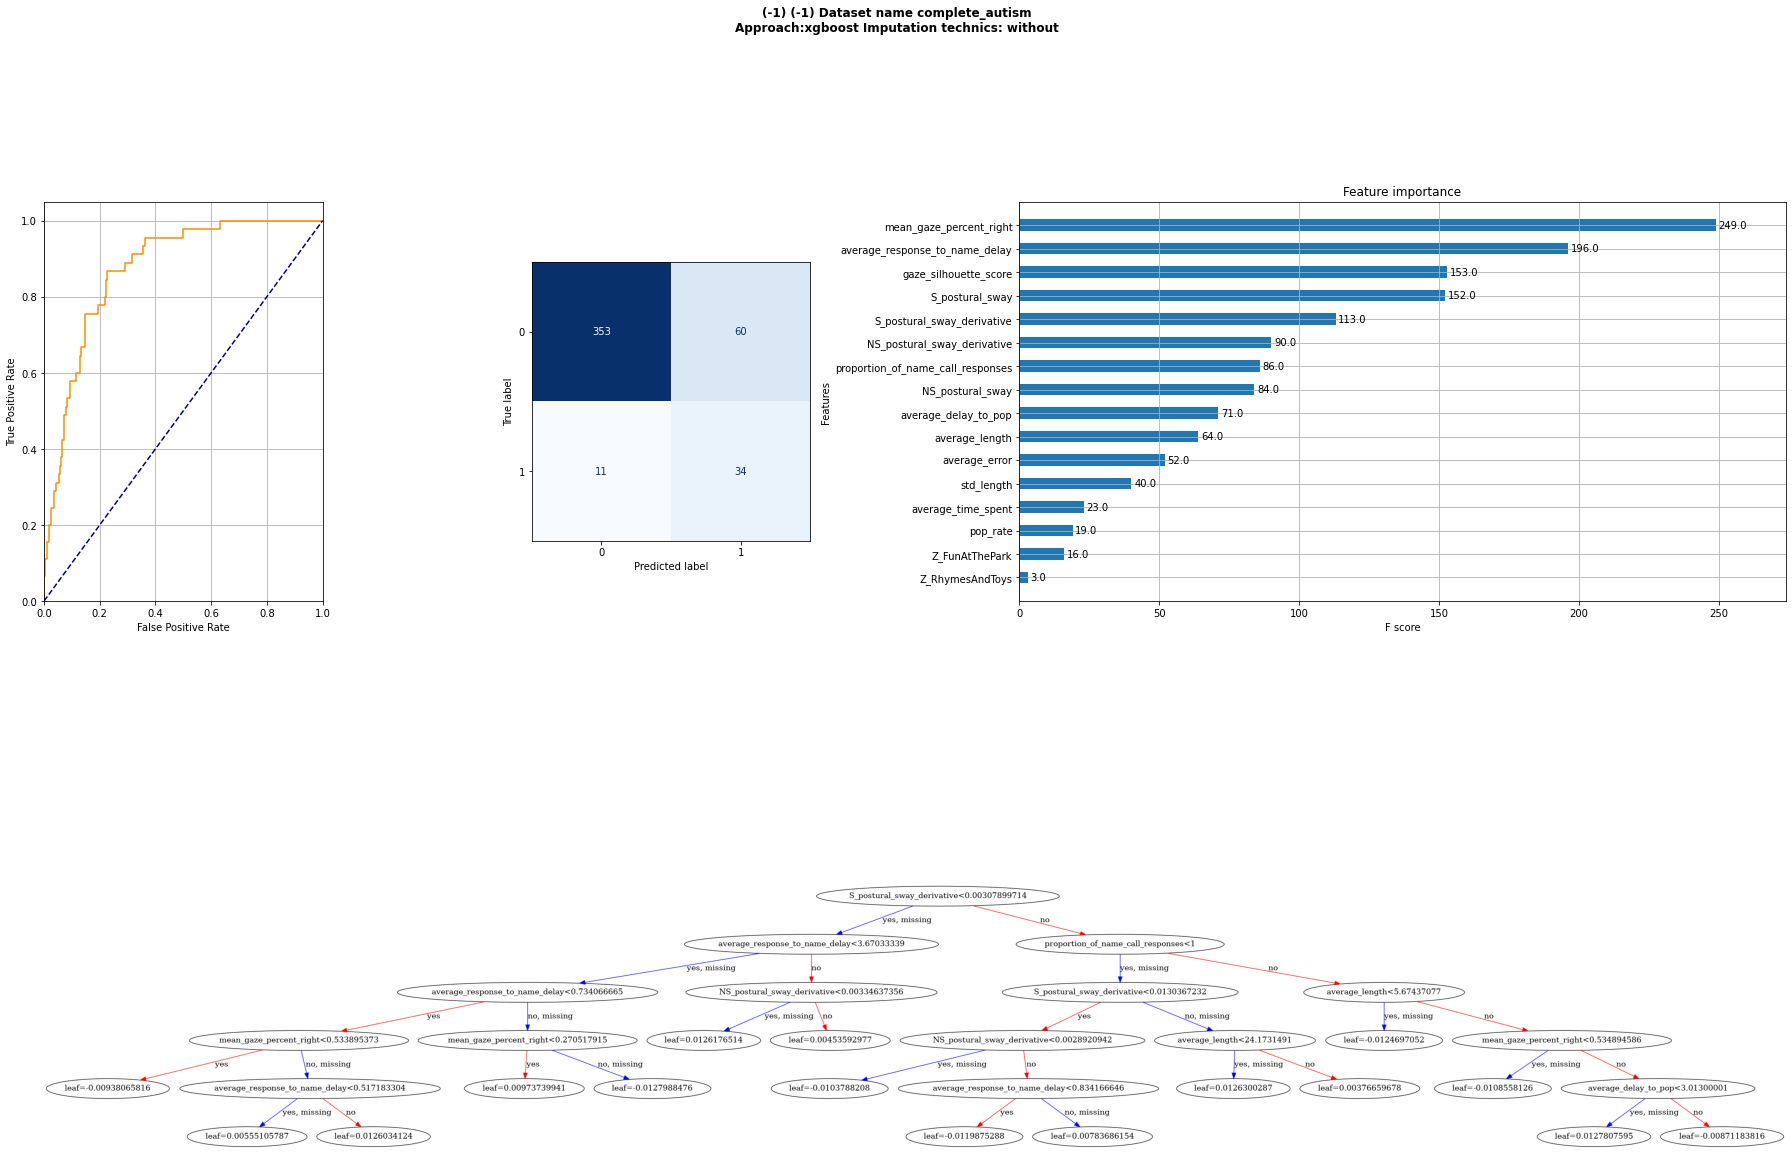

In [70]:
exp.plot()

In [45]:
index

array([ 14,  17,  19,  24,  31,  34,  39,  40,  42,  46,  47,  48,  58,
        67,  68,  69,  76,  78,  92,  97, 105, 115, 120, 127, 135, 137,
       145, 159, 166, 168, 169, 175, 186, 191, 202, 211, 220, 225, 228,
       232, 236, 239, 252, 259, 271, 276, 278, 286, 309, 313, 314, 352,
       354, 381, 392, 394, 422, 425, 431, 452])

In [46]:
name

'FP'

# Detailed results per missing data

In [274]:
from model.xgboost.visualization import plot_roc_curves_xgboost

def compute_results(dataframe, y_true, y_pred, threshold, name='?', title=""):
    
    # Compute first AUROC
    auroc = roc_auc_score(y_true, y_pred)

    # Compute the AUC-PR
    auc_pr = average_precision_score(y_true, y_pred)

    # Compute the AUC-PR Corrected
    auc_pr_corrected = average_precision(y_true, y_pred, pi0=REFERENCE_IMBALANCE_RATIO)

    # Compute the AUC-PR Gain
    auc_pr_g = prg.calc_auprg(prg.create_prg_curve(y_true, y_pred))

    # Compute the AUC-PR Gain corrected
    auc_pr_g_corrected = calc_auprg(create_prg_curve(y_true, y_pred, pi0=REFERENCE_IMBALANCE_RATIO))

    # Compute the F1 score
    f1, _ = bestf1score(y_true, y_pred, pi0=None)

    # Compute the corrected F1 score
    f1_corrected, _ = bestf1score(y_true, y_pred, pi0=REFERENCE_IMBALANCE_RATIO)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred >= threshold).ravel()

    acc = (tp + tn) / (tp + tn + fp +  fn)
    mcc = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    tpr =  tp / (tp+fn)
    tnr = tn / (tn+fp)
    ppv = tp / (tp+fp)
    npv = tn / (tn+fn)
    fnr = fn / (tp+fn)

    performances_dict = {'AUROC':round(auroc, 3),
                        'AUC-PR': round(auc_pr, 3),
                        'AUC-PR-Gain': round(auc_pr_g, 3),
                        'AUC-PR-Corrected': round(auc_pr_corrected, 3),
                        'AUC-PR-Gain-Corrected' :round(auc_pr_g_corrected, 3),
                        'F1 score (2 PPVxTPR/(PPV+TPR))': round(f1, 3),
                        'F1 score Corrected': round(f1_corrected, 3),
                        'Accuracy' : round(acc, 3),
                        'Matthews correlation coefficient (MCC)': round(mcc, 3),
                        'Sensitivity, recall, hit rate, or true positive rate (TPR)': round(tpr, 3),
                        'Specificity, selectivity or true negative rate (TNR)': round(tnr, 3),
                        'Precision or positive predictive value (PPV)': round(ppv, 3),
                        'Negative predictive value (NPV)': round(npv, 3),
                        'Miss rate or false negative rate (FNR)': round(fnr, 3),
                        'False discovery rate (FDR=1-PPV)': round(1-ppv, 3),
                        'False omission rate (FOR=1-NPV)': round(1-npv, 3)}

    
    performances_df = pd.DataFrame(performances_dict, index=[name])

    performances_df['TN'] = tn
    performances_df['TP'] = tp
    performances_df['FP'] = fp
    performances_df['FN'] = fn

    performances_df['TN_normalized'] = 100*tn/len(y_true)
    performances_df['TP_normalized'] = 100*tp/len(y_true)
    performances_df['FP_normalized'] =  100*fp/len(y_true)
    performances_df['FN_normalized'] =  100*fn/len(y_true)    
    performances_df['N'] = len(y_true) 
    
    display(performances_df)

    fig_mosaic = """
                    AB
                """

    fig, axes = plt.subplot_mosaic(mosaic=fig_mosaic, figsize=(10,5))

    fig.suptitle(title, y=1.1, weight='bold', fontsize=12)

    cm = confusion_matrix(y_true, y_pred >= threshold)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', ax=axes['B']);disp.im_.colorbar.remove()    

    # Plot the roc curves
    axes['A'] = plot_roc_curves_xgboost(dataframe, ax=axes['A']) 
    plt.tight_layout()
    plt.show()
    return performances_df

grouped_missing_features = {'mean_gaze_percent_right': ['mean_gaze_percent_right'],
                             'gaze_silhouette_score': ['gaze_silhouette_score'],
                             'proportion_of_name_call_responses': ['proportion_of_name_call_responses'],
                             'average_response_to_name_delay': ['average_response_to_name_delay'],
                            
                             'S_postural_sway': ['S_postural_sway'],
                             'NS_postural_sway': ['NS_postural_sway'],
                             'S_postural_sway': ['S_postural_sway'],
                             'S_postural_sway_derivative': ['S_postural_sway_derivative'],
                             'NS_postural_sway_derivative': ['NS_postural_sway_derivative'],
                             'Game': ['average_length','std_length','average_error', 'pop_rate','average_delay_to_pop','average_time_spent']}


def having_missing(df, features, contrary=True):
    if not contrary:
        return df.loc[df.drop(index=df.dropna(subset=features, how='all').index).index, :]
    else:
        return df.dropna(subset=features, how='all')
    
    
def select(df, feat, value):
    return df[df[feat]==value]   

In [194]:
variables_of_interest = CVA_COLUMNS
self=exp

X  = deepcopy(self.predictions_df[self.features_name])
dataset = X.copy()

vars = dataset.dtypes.index.values
n_var = dataset.shape[1]
# mean and covariance estimates
# ideally, this is done with a maximum likelihood estimator
gmean = dataset.mean()
gcov = dataset.cov()

# set up missing data patterns
r = 1 * dataset.isnull()
mdp = np.dot(r, list(map(lambda x: pow(2, x), range(n_var))))
sorted_mdp = sorted(np.unique(mdp))
n_pat = len(sorted_mdp)
correct_mdp = list(map(lambda x: sorted_mdp.index(x), mdp))
self.predictions_df["mdp"] = pd.Series(correct_mdp, index=dataset.index)

In [196]:

dataframe = deepcopy(exp.predictions_df)
variables_of_interest = exp.features_name
for name_missing, feature_missing  in grouped_missing_features.items():
    
    print("{} {:.2f}% with {:.2f} NT and {:.2f} autistic".format(name_missing, 100*len(having_missing(dataframe, feature_missing, contrary=False))/len(dataframe), 
                                                                 100*round(len(having_missing(select(dataframe, 'y_true', 0), feature_missing, contrary=False))/len(select(dataframe, 'y_true', 0)), 2), 
                                                                 100*round(len(having_missing(select(dataframe, 'y_true', 1), feature_missing, contrary=False))/len(select(dataframe, 'y_true', 1)), 2)))

mean_gaze_percent_right 5.24% with 5.00 NT and 9.00 autistic
gaze_silhouette_score 5.02% with 5.00 NT and 7.00 autistic
proportion_of_name_call_responses 0.87% with 1.00 NT and 2.00 autistic
average_response_to_name_delay 25.55% with 25.00 NT and 31.00 autistic
S_postural_sway 4.80% with 5.00 NT and 7.00 autistic
NS_postural_sway 0.00% with 0.00 NT and 0.00 autistic
S_postural_sway_derivative 4.80% with 5.00 NT and 7.00 autistic
NS_postural_sway_derivative 0.00% with 0.00 NT and 0.00 autistic
Game 34.06% with 34.00 NT and 38.00 autistic


In [422]:
dataframe["mdp"].value_counts()

0     192
12     94
1      53
13     41
3      30
14     13
5      13
16      5
10      5
2       2
17      2
8       2
4       1
15      1
7       1
9       1
11      1
6       1
Name: mdp, dtype: int64

Number of missing patterns: 18


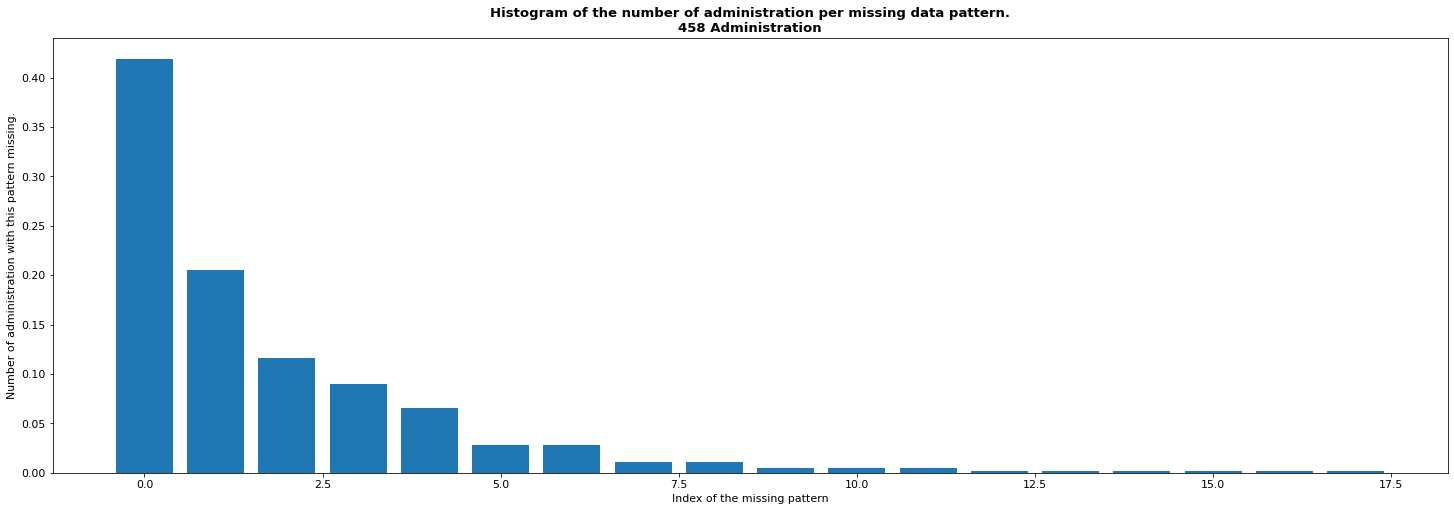

In [421]:
plt.figure(figsize=(25, 8))
plt.bar(x=np.arange((len(dataframe["mdp"].value_counts().index))), height=dataframe["mdp"].value_counts(normalize=True).to_numpy())
plt.title("Histogram of the number of administration per missing data pattern.\n{} Administration".format(len(dataframe)), weight='bold');plt.xlabel("Index of the missing pattern"); plt.ylabel("Number of administration with this pattern missing.")
print("Number of missing patterns: {}".format(n_pat))
matrix = pd.DataFrame(
            data=np.zeros(shape=(len(dataframe["mdp"].value_counts().index), len(exp.features_name)+1)),
            columns=exp.features_name+['Percentage of rows'],
            index=dataframe["mdp"].unique(),
        ).sort_index()

Text(0.5, 1.0, 'Features missing for the most frequent patterns. 461 adm (415 NT, 46 ASD)')

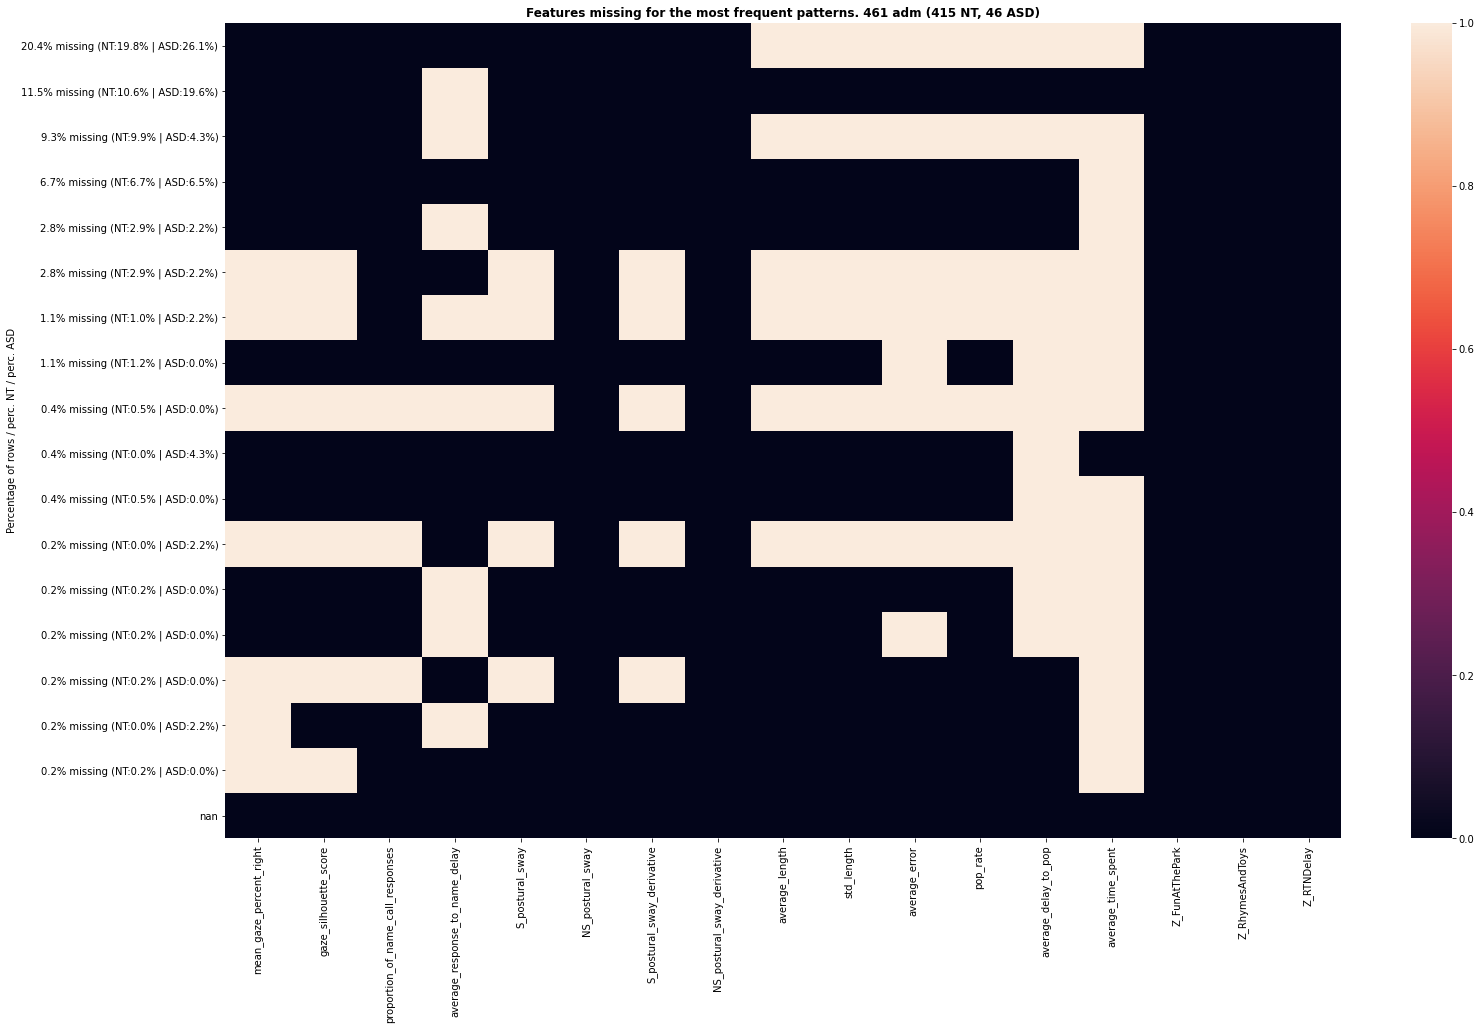

In [83]:
for pattern in sorted(dataframe["mdp"].unique())[1:]:
    d = dataframe.loc[dataframe['mdp']==pattern, ['y_true'] + variables_of_interest]
    missing_columns = list(d.columns[d.isnull().any()])
    matrix.loc[pattern, missing_columns] = 1
    matrix.loc[pattern, 'Percentage of rows'] = np.round(len(d)/len(dataframe)*100,2)
    #matrix.loc[pattern, 'Percentage of rows (autism)'] = np.round(len(d[d['diagnosis']==0])/len(data.df[data.df['diagnosis']==0])*100,2)
    #matrix.loc[pattern, 'Percentage of rows (NT)'] = np.round(len(d[d['diagnosis']==1])/len(data.df[data.df['diagnosis']==1])*100,2)
    matrix.loc[pattern, 'Percentage of rows / perc. NT / perc. ASD'] = "{}% missing (NT:{}% | ASD:{}%)".format(np.round(len(d)/len(dataframe)*100,1), np.round(len(d[d['y_true']==0])/len(dataframe[dataframe['y_true']==0])*100,1), np.round(len(d[d['y_true']==1])/len(dataframe[dataframe['y_true']==1])*100,1))
matrix.sort_values('Percentage of rows', ascending=False, inplace=True)
plt.figure(figsize=(25, 15))
sns.heatmap(matrix.set_index('Percentage of rows / perc. NT / perc. ASD').loc[:, variables_of_interest].astype(int))
plt.title("Features missing for the most frequent patterns. {} adm ({} NT, {} ASD)".format(len(dataframe), len(dataframe[dataframe['y_true']==0]), len(data.df[dataframe['y_true']==1])), weight='bold')



In [177]:
def having_missing(df, features, contrary=True):
    if not contrary:
        return df.loc[df.drop(index=df.dropna(subset=features, how='all').index).index, :]
    else:
        return df.dropna(subset=features, how='all')
    
    

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized
?,0.899,0.503,0.97,0.327,0.99,0.485,0.344,0.865,0.463,0.846,0.866,0.314,0.987,0.154,0.686,0.013,155,11,24,2,0.807292,0.057292,0.125,0.010417


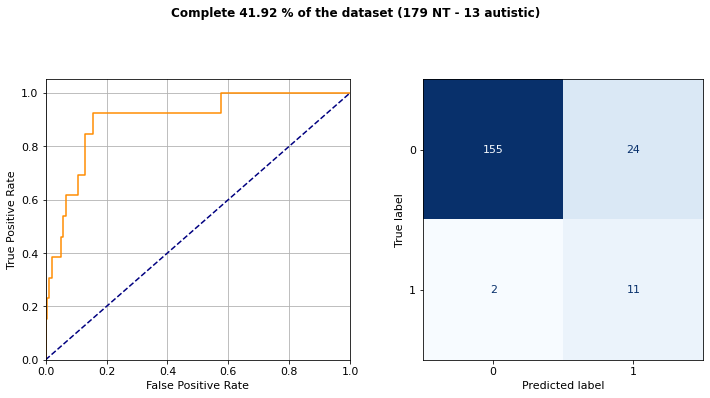

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized
?,0.855,0.507,0.868,0.207,0.967,0.522,0.28,0.851,0.421,0.583,0.89,0.438,0.936,0.417,0.562,0.064,73,7,9,5,0.776596,0.074468,0.095745,0.053191


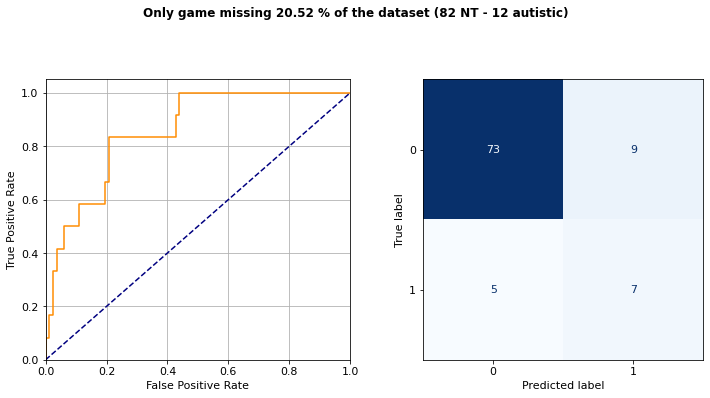

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized
?,0.939,0.666,0.897,0.197,0.838,0.778,0.417,0.887,0.677,0.889,0.886,0.615,0.975,0.111,0.385,0.025,39,8,5,1,0.735849,0.150943,0.09434,0.018868


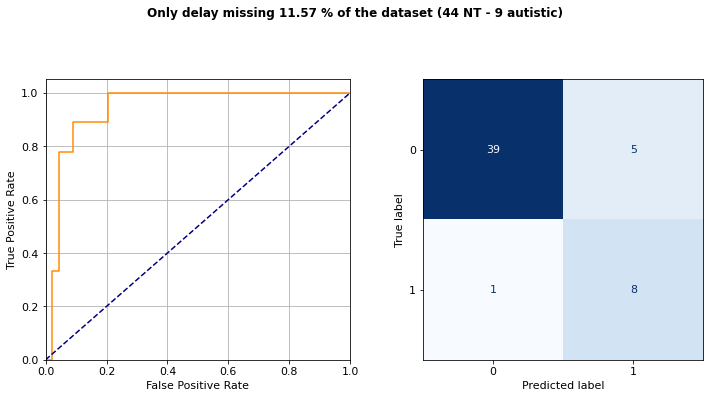

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized
?,0.654,0.204,0.403,0.11,0.166,0.4,0.27,0.78,0.153,0.5,0.795,0.111,0.969,0.5,0.889,0.031,31,1,8,1,0.756098,0.02439,0.195122,0.02439


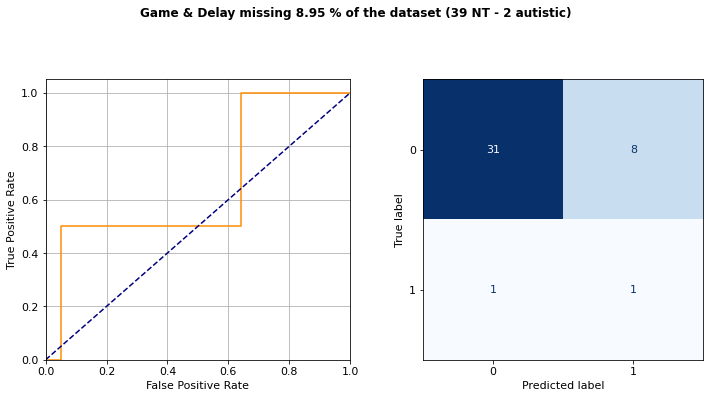

In [227]:
from metrics import f1score, average_precision, bestf1score, calc_auprg, create_prg_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, plot_roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score
import prg

dataframe = deepcopy(exp.predictions_df)
mapping_name = {0: "Complete", 
                12: "Only game missing", 
                1: "Only delay missing", 
                13: "Game & Delay missing"}

#for mdp_index in mapping_name.keys():
#    d = dataframe[dataframe['mdp']==mdp_index]

grouped_missing_features = {'None': DEFAULT_PREDICTORS,
                            'mean_gaze_percent_right': ['mean_gaze_percent_right'],
                             'gaze_silhouette_score': ['gaze_silhouette_score'],
                             'proportion_of_name_call_responses': ['proportion_of_name_call_responses'],
                             'average_response_to_name_delay': ['average_response_to_name_delay'],
                            
                             'S_postural_sway': ['S_postural_sway'],
                             'NS_postural_sway': ['NS_postural_sway'],
                             'S_postural_sway': ['S_postural_sway'],
                             'S_postural_sway_derivative': ['S_postural_sway_derivative'],
                             'NS_postural_sway_derivative': ['NS_postural_sway_derivative'],
                             'Game': ['average_length','std_length','average_error', 'pop_rate','average_delay_to_pop','average_time_spent'], 
                             }

for mdp_index in mapping_name.keys():
    d = dataframe[dataframe['mdp']==mdp_index]

    
    title = mapping_name[mdp_index]
    title+= " {:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(d)/len(dataframe), len(d[d['y_true']==0]), len(d[d['y_true']==1]))
    
    y_true = d['y_true'].to_numpy()
    y_pred = d['y_pred'].to_numpy()

    compute_results(d, y_true, y_pred, exp.optimal_threshold, title=title)
    
    

In [234]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curves_xgboost(predictions_df, ax = None):

    if ax is None:
        fig, ax =  plt.subplots(1, 1, figsize=(5, 5))

    fpr, tpr, _ = roc_curve(predictions_df['y_true'], predictions_df['y_pred']); roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, '-', color='darkorange', lw=1.5, label='ROC curve (area = %0.2f)' % roc_auc,)
    ax.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
    ax.set_xlim([0.0, 1.0]); ax.set_ylim([0.0, 1.05]); ax.grid()
    ax.set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')
    return ax

## How the model performs of subgroups of data. 

Here we look at the performances when considering subsets of data by removing the participants missing a feature. 
E.G what are the performances if we remove the participants that miss one feature ? Is it better or worse ? We expect the performances are better, if the hypothess thta missing a feature entails a loss of information in the input, so we expect the model to perform worse on those data. 

Note that another way to look at that is isolating participants with missing a feature and look at the performances. 

In [353]:
variables

['average_length',
 'std_length',
 'average_error',
 'pop_rate',
 'average_delay_to_pop',
 'average_time_spent']

,mean_gaze_percent_right,gaze_silhouette_score,proportion_of_name_call_responses,average_response_to_name_delay,S_postural_sway,NS_postural_sway,S_postural_sway_derivative,NS_postural_sway_derivative,average_length,std_length,average_error,pop_rate,average_delay_to_pop,average_time_spent,Z_FunAtThePark,Z_RhymesAndToys,y_true,y_pred,TN,TP,FP,FN,mdp
1,0.481269,0.582087,1.000000,1.384717,0.205969,1.238350,0.000476,0.013931,7.781981,6.760262,11.703175,0.800000,2.695000,0.741000,0.0,0.0,0.0,0.185665,1,0,0,0,0
3,0.434169,0.393004,1.000000,0.556111,2.978287,2.007431,0.016263,0.006172,6.856880,8.420087,11.981659,0.888889,3.211286,0.927000,0.0,0.0,0.0,0.395438,0,0,1,0,0
13,0.568734,0.649091,1.000000,0.912022,0.164098,0.546002,0.000375,0.002896,4.849639,5.443136,14.357930,0.611111,2.337667,1.780000,0.0,0.0,0.0,0.204322,1,0,0,0,0
14,0.582219,0.394149,1.000000,1.084417,1.571709,2.184546,0.008108,0.014957,2.046430,4.182066,6.934383,1.000000,3.039333,0.394667,0.0,0.0,0.0,0.529841,0,0,1,0,0
15,0.617876,0.523076,0.666667,1.735067,2.422486,3.209192,0.010437,0.013588,4.103233,4.168139,9.086770,0.954545,2.194867,0.605200,0.0,0.0,1.0,0.547475,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,0.501621,0.570985,0.333333,0.433767,0.597399,0.570025,0.004312,0.003997,130.192765,209.151826,27.867744,0.166667,3.332500,0.415000,0.0,0.0,0.0,0.292758,1,0,0,0,0
443,0.534895,0.707216,1.000000,0.850850,0.491351,1.628709,0.002315,0.008190,0.389595,1.292140,7.212946,0.916667,3.155429,0.667333,0.0,0.0,0.0,0.203103,1,0,0,0,0
445,0.593662,0.515159,1.000000,0.912022,0.803349,1.341194,0.005299,0.007576,5.853236,4.644631,11.603609,0.875000,2.380095,0.666125,0.0,0.0,1.0,0.397276,0,1,0,0,0
449,0.523815,0.620826,0.333333,1.134467,0.255300,0.696718,0.000736,0.005474,7.683597,8.809438,10.126427,0.916667,2.597000,1.087500,0.0,0.0,0.0,0.192317,1,0,0,0,0


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
None,0.899,0.503,0.97,0.327,0.99,0.485,0.344,0.865,0.463,0.846,0.866,0.314,0.987,0.154,0.686,0.013,155,11,24,2,80.729167,5.729167,12.5,1.041667,192


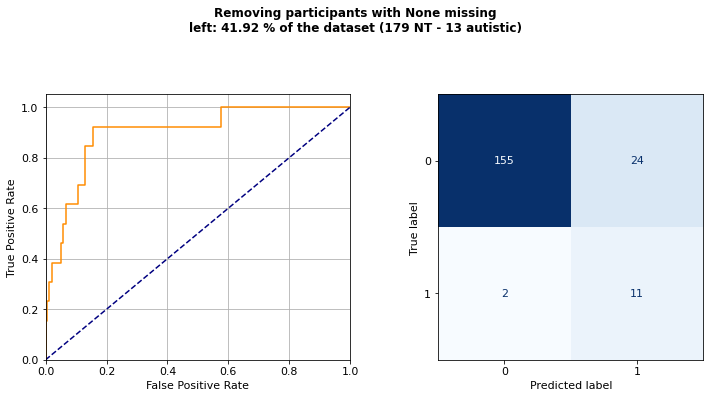

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
Gaze_PR,0.896,0.477,0.891,0.218,0.973,0.542,0.264,0.871,0.501,0.78,0.88,0.405,0.975,0.22,0.595,0.025,346,32,47,9,79.723502,7.373272,10.829493,2.073733,434


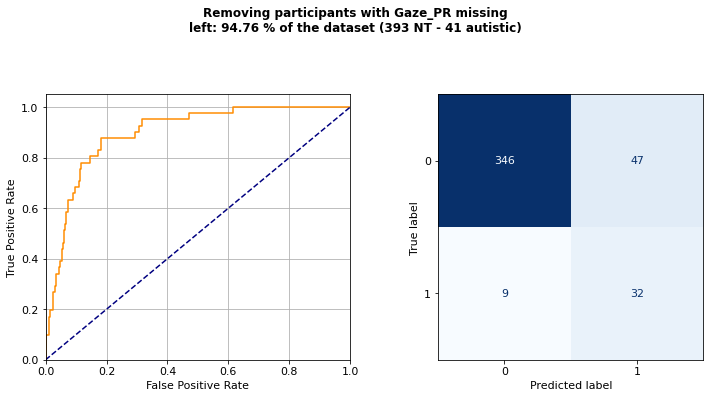

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
Gaze_SS,0.895,0.476,0.886,0.214,0.972,0.541,0.259,0.871,0.508,0.786,0.88,0.412,0.975,0.214,0.588,0.025,346,33,47,9,79.54023,7.586207,10.804598,2.068966,435


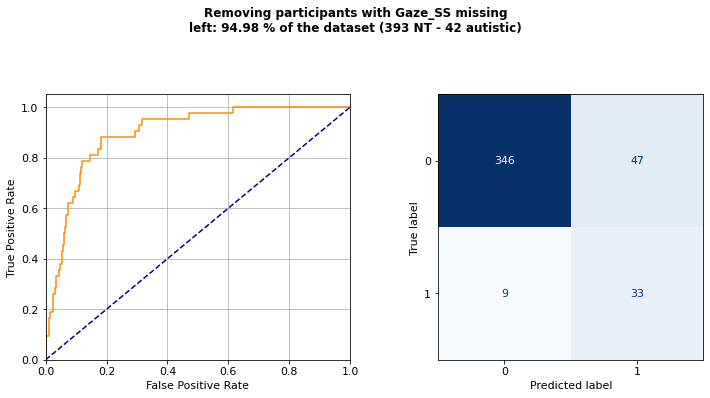

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
RTN_f,0.881,0.442,0.876,0.194,0.968,0.5,0.229,0.848,0.461,0.773,0.856,0.366,0.972,0.227,0.634,0.028,351,34,59,10,77.312775,7.488987,12.995595,2.202643,454


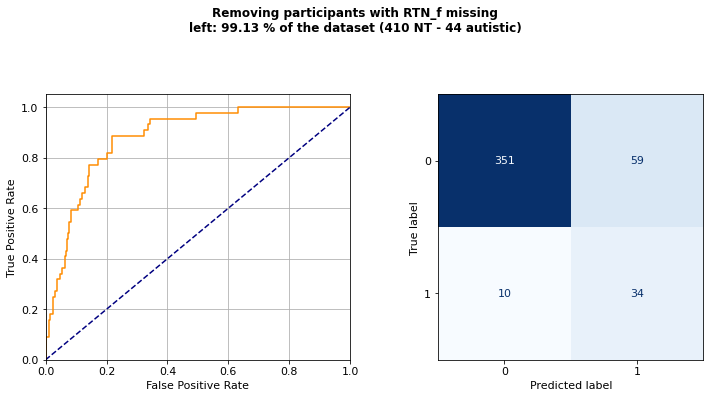

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
RTN_d,0.877,0.478,0.932,0.257,0.984,0.486,0.274,0.848,0.418,0.71,0.861,0.338,0.967,0.29,0.662,0.033,267,22,43,9,78.29912,6.451613,12.609971,2.639296,341


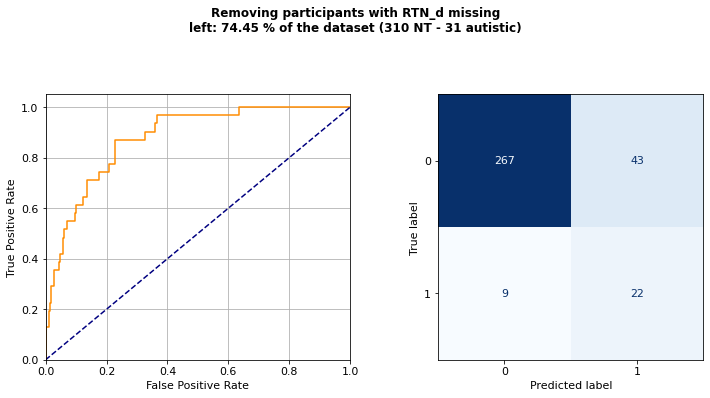

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
S_PS,0.895,0.475,0.886,0.213,0.972,0.537,0.259,0.869,0.504,0.786,0.878,0.407,0.975,0.214,0.593,0.025,346,33,48,9,79.357798,7.568807,11.009174,2.06422,436


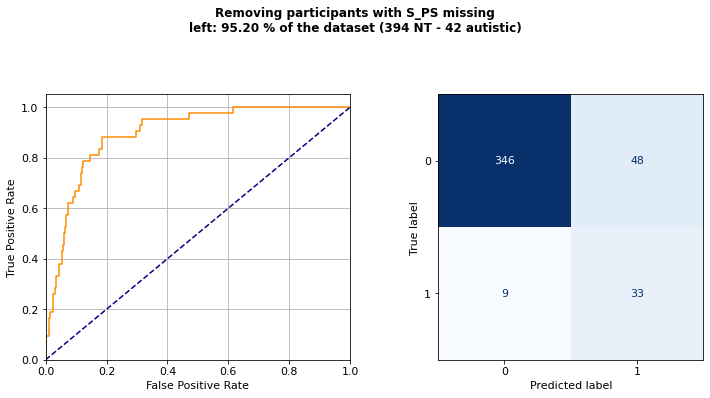

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
NS_PS,0.873,0.43,0.872,0.187,0.967,0.482,0.217,0.841,0.443,0.756,0.85,0.354,0.97,0.244,0.646,0.03,351,34,62,11,76.637555,7.423581,13.537118,2.401747,458


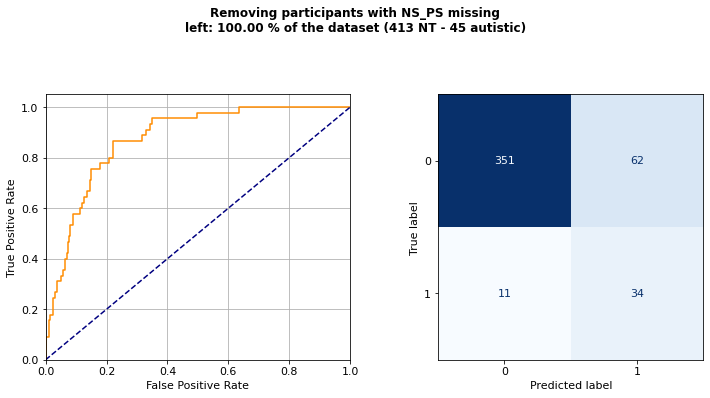

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
S_PSd,0.895,0.475,0.886,0.213,0.972,0.537,0.259,0.869,0.504,0.786,0.878,0.407,0.975,0.214,0.593,0.025,346,33,48,9,79.357798,7.568807,11.009174,2.06422,436


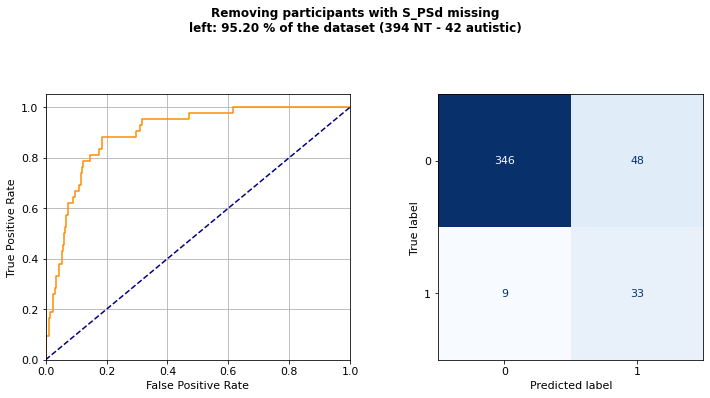

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
NS_PSd,0.873,0.43,0.872,0.187,0.967,0.482,0.217,0.841,0.443,0.756,0.85,0.354,0.97,0.244,0.646,0.03,351,34,62,11,76.637555,7.423581,13.537118,2.401747,458


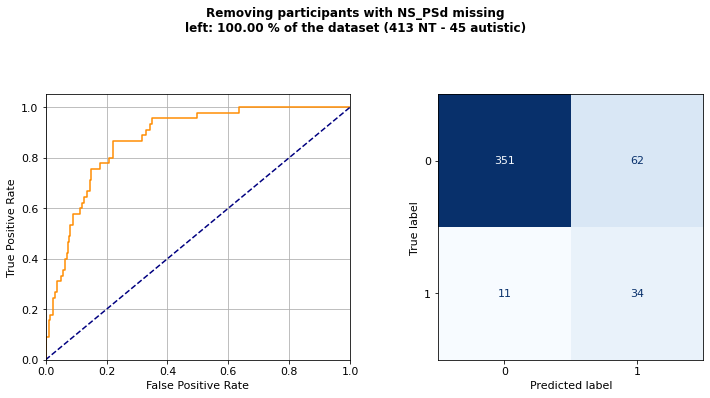

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
Game,0.91,0.491,0.911,0.218,0.96,0.577,0.298,0.869,0.528,0.864,0.87,0.396,0.985,0.136,0.604,0.015,194,19,29,3,79.183673,7.755102,11.836735,1.22449,245


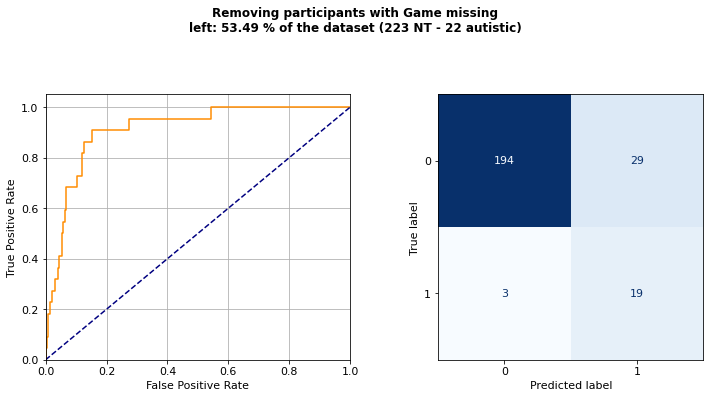

In [405]:
from metrics import f1score, average_precision, bestf1score, calc_auprg, create_prg_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, plot_roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score
import prg


mapping_name = {0: "Complete", 
                12: "Only game missing", 
                1: "Only delay missing", 
                13: "Game & Delay missing"}

#for mdp_index in mapping_name.keys():
#    d = dataframe[dataframe['mdp']==mdp_index]

grouped_missing_features = {#'All': [], 
                            'None':DEFAULT_PREDICTORS,
                            'Gaze_PR': ['mean_gaze_percent_right'],
                             'Gaze_SS': ['gaze_silhouette_score'],
                             'RTN_f': ['proportion_of_name_call_responses'],
                             'RTN_d': ['average_response_to_name_delay'],
                            
                             'S_PS': ['S_postural_sway'],
                             'NS_PS': ['NS_postural_sway'],
                             'S_PSd': ['S_postural_sway_derivative'],
                             'NS_PSd': ['NS_postural_sway_derivative'],
                             'Game': ['average_length','std_length','average_error', 'pop_rate','average_delay_to_pop','average_time_spent'], 
                             }

results = deepcopy(exp.performances_df)

results.index = ['All']

for name in ['TP','FN', 'TN', 'FP']:
    results[name] = exp.predictions_df[name].sum()
    
for name in ['TP','FN', 'TN', 'FP']:
    results[name+'_normalized'] = 100*exp.predictions_df[name].mean().round(2)

results['N'] = len(exp.predictions_df)



for missing, variables in grouped_missing_features.items():
    
    d=dataframe.dropna(subset=variables, how='any') 

    
    title = "Removing participants with {} missing".format(missing)
    title+= "\nleft: {:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(d)/len(dataframe), len(d[d['y_true']==0]), len(d[d['y_true']==1]))
    
    y_true = d['y_true'].to_numpy()
    y_pred = d['y_pred'].to_numpy()
    
    
    

    res = compute_results(d, y_true, y_pred, exp.optimal_threshold, name=missing, title=title)
    
    results = results.append(res)
    
    

[] 458


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
All,0.873,0.43,0.872,0.187,0.967,0.482,0.217,0.841,0.443,0.756,0.85,0.354,0.97,0.244,0.646,0.03,351,34,62,11,76.637555,7.423581,13.537118,2.401747,458


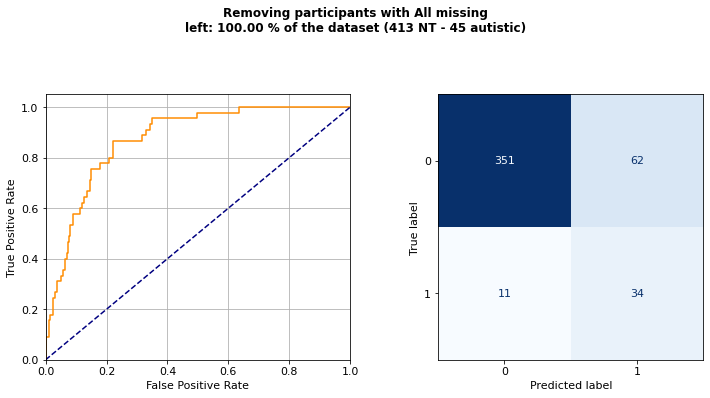

['mean_gaze_percent_right', 'gaze_silhouette_score', 'proportion_of_name_call_responses', 'average_response_to_name_delay', 'S_postural_sway', 'NS_postural_sway', 'S_postural_sway_derivative', 'NS_postural_sway_derivative', 'average_length', 'std_length', 'average_error', 'pop_rate', 'average_delay_to_pop', 'average_time_spent'] 192


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
None,0.899,0.503,0.97,0.327,0.99,0.485,0.344,0.865,0.463,0.846,0.866,0.314,0.987,0.154,0.686,0.013,155,11,24,2,80.729167,5.729167,12.5,1.041667,192


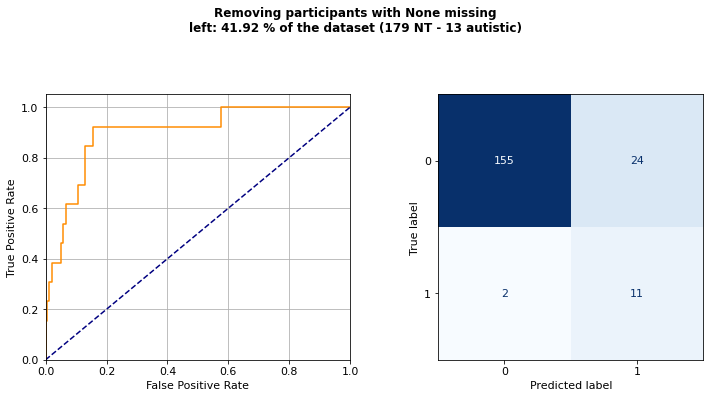

['mean_gaze_percent_right'] 434


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
Gaze_PR,0.896,0.477,0.891,0.218,0.973,0.542,0.264,0.871,0.501,0.78,0.88,0.405,0.975,0.22,0.595,0.025,346,32,47,9,79.723502,7.373272,10.829493,2.073733,434


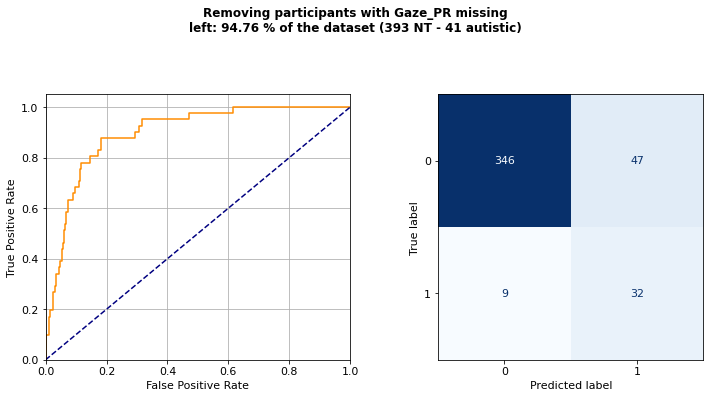

['gaze_silhouette_score'] 435


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
Gaze_SS,0.895,0.476,0.886,0.214,0.972,0.541,0.259,0.871,0.508,0.786,0.88,0.412,0.975,0.214,0.588,0.025,346,33,47,9,79.54023,7.586207,10.804598,2.068966,435


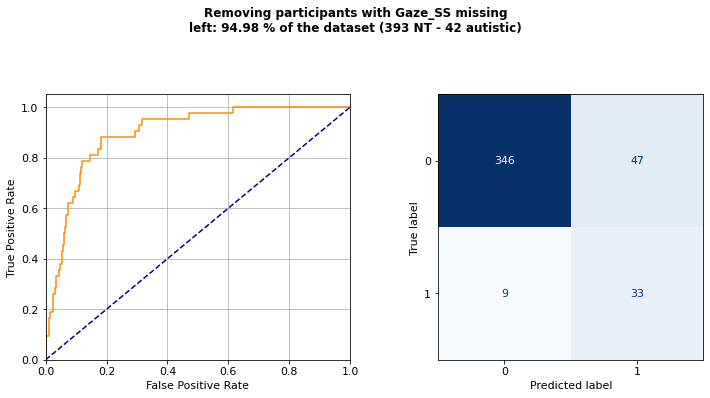

['proportion_of_name_call_responses'] 454


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
RTN_f,0.881,0.442,0.876,0.194,0.968,0.5,0.229,0.848,0.461,0.773,0.856,0.366,0.972,0.227,0.634,0.028,351,34,59,10,77.312775,7.488987,12.995595,2.202643,454


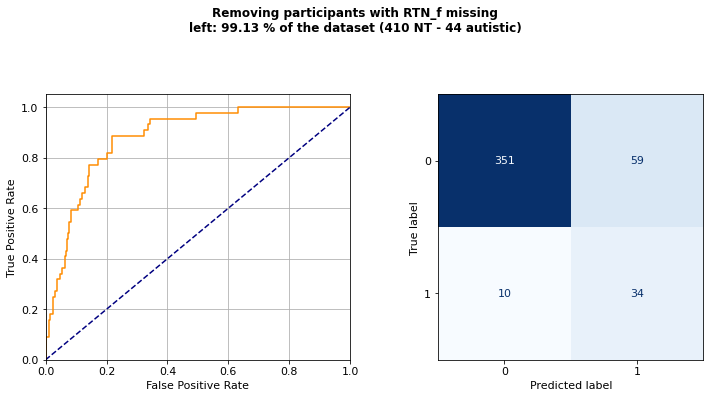

['average_response_to_name_delay'] 341


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
RTN_d,0.877,0.478,0.932,0.257,0.984,0.486,0.274,0.848,0.418,0.71,0.861,0.338,0.967,0.29,0.662,0.033,267,22,43,9,78.29912,6.451613,12.609971,2.639296,341


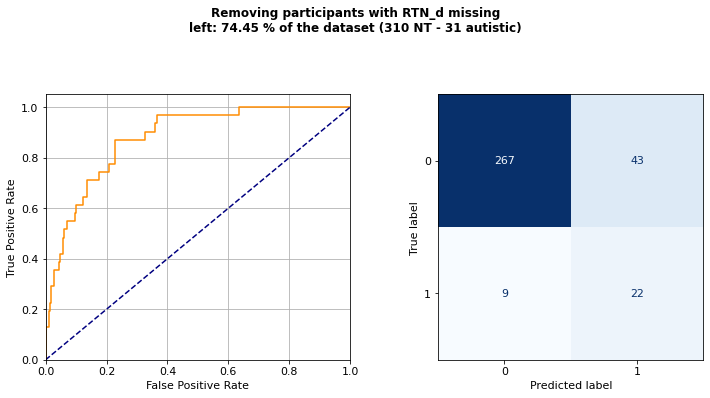

['S_postural_sway'] 436


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
S_PS,0.895,0.475,0.886,0.213,0.972,0.537,0.259,0.869,0.504,0.786,0.878,0.407,0.975,0.214,0.593,0.025,346,33,48,9,79.357798,7.568807,11.009174,2.06422,436


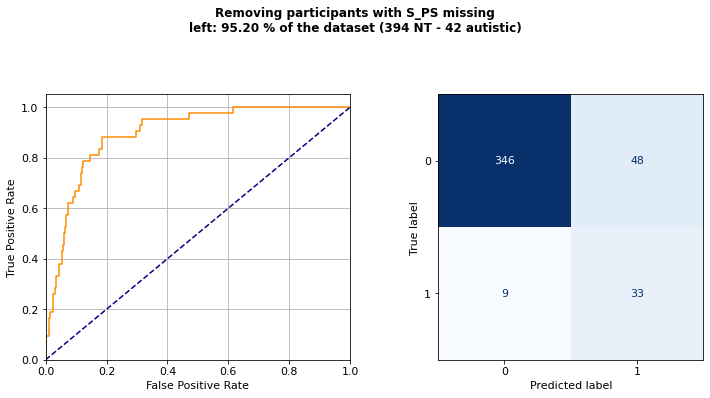

['NS_postural_sway'] 458


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
NS_PS,0.873,0.43,0.872,0.187,0.967,0.482,0.217,0.841,0.443,0.756,0.85,0.354,0.97,0.244,0.646,0.03,351,34,62,11,76.637555,7.423581,13.537118,2.401747,458


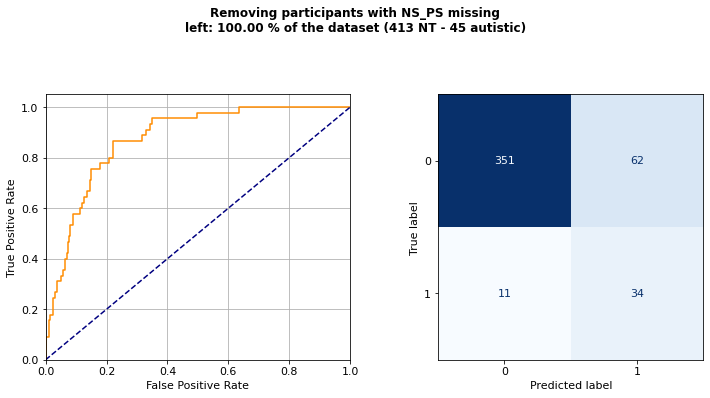

['S_postural_sway_derivative'] 436


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
S_PSd,0.895,0.475,0.886,0.213,0.972,0.537,0.259,0.869,0.504,0.786,0.878,0.407,0.975,0.214,0.593,0.025,346,33,48,9,79.357798,7.568807,11.009174,2.06422,436


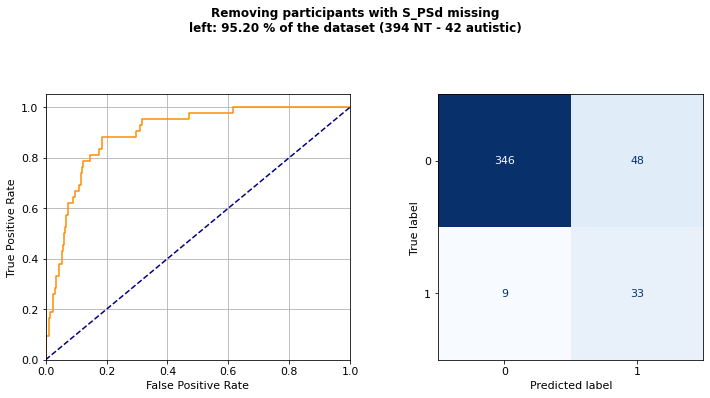

['NS_postural_sway_derivative'] 458


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
NS_PSd,0.873,0.43,0.872,0.187,0.967,0.482,0.217,0.841,0.443,0.756,0.85,0.354,0.97,0.244,0.646,0.03,351,34,62,11,76.637555,7.423581,13.537118,2.401747,458


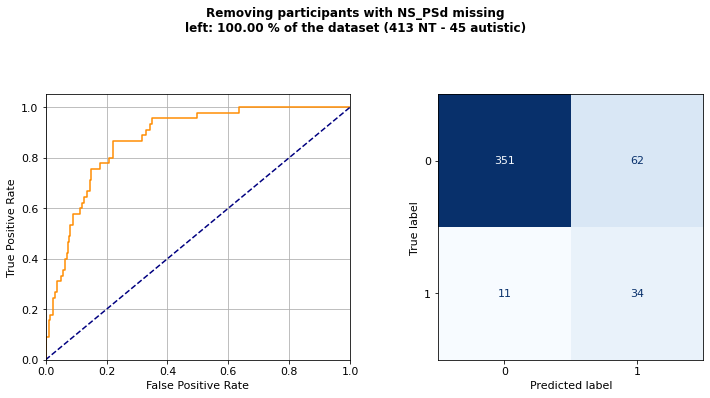

['average_length', 'std_length', 'average_error', 'pop_rate', 'average_delay_to_pop', 'average_time_spent'] 245


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
Game,0.91,0.491,0.911,0.218,0.96,0.577,0.298,0.869,0.528,0.864,0.87,0.396,0.985,0.136,0.604,0.015,194,19,29,3,79.183673,7.755102,11.836735,1.22449,245


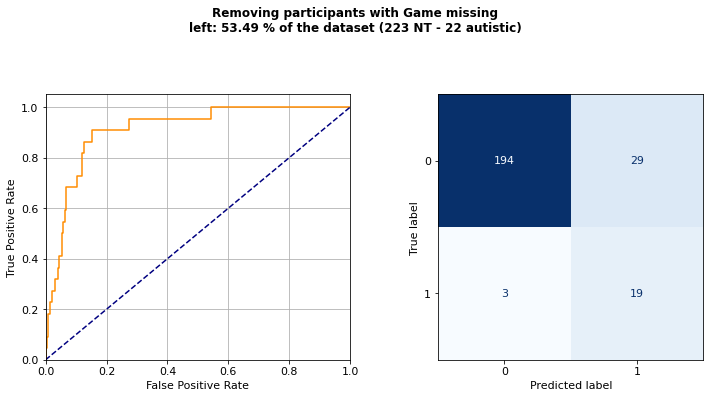

In [397]:

results = deepcopy(exp.performances_df)

results.index = ['All']

for name in ['TP','FN', 'TN', 'FP']:
    results[name] = exp.predictions_df[name].sum()
    
for name in ['TP','FN', 'TN', 'FP']:
    results[name+'_normalized'] = 100*exp.predictions_df[name].mean().round(2)

results['N'] = len(exp.predictions_df)

df_with_none_missing = deepcopy(dataframe.dropna(subset=exp.features_name, how='any'))


for missing, variables in grouped_missing_features.items():
    
    d=dataframe.dropna(subset=variables, how='any') 
    
     
    # df with rows having variable missing 
    
    #d = df_with_none_missing.append(dataframe.drop(index=dataframe.dropna(subset=variables, how='any').index))


    print(variables, len(d))
    title = "Removing participants with {} missing".format(missing)
    title+= "\nleft: {:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(d)/len(dataframe), len(d[d['y_true']==0]), len(d[d['y_true']==1]))
    
    y_true = d['y_true'].to_numpy()
    y_pred = d['y_pred'].to_numpy()
    
    
    

    res = compute_results(d, y_true, y_pred, exp.optimal_threshold, name=missing, title=title)
    
    results = results.append(res)
    
    
    
   

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
Male,0.847,0.44,0.775,0.147,0.937,0.542,0.17,0.82,0.472,0.765,0.829,0.419,0.956,0.235,0.581,0.044,174,26,36,8,71.311475,10.655738,14.754098,3.278689,244


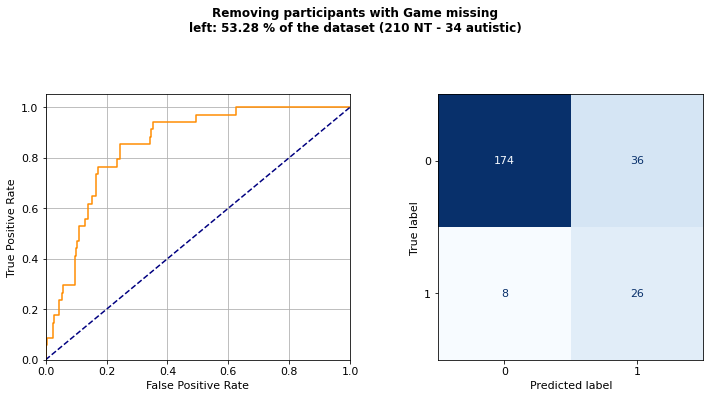

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
Female,0.926,0.534,0.986,0.399,0.994,0.56,0.408,0.864,0.362,0.727,0.872,0.235,0.983,0.273,0.765,0.017,177,8,26,3,82.71028,3.738318,12.149533,1.401869,214


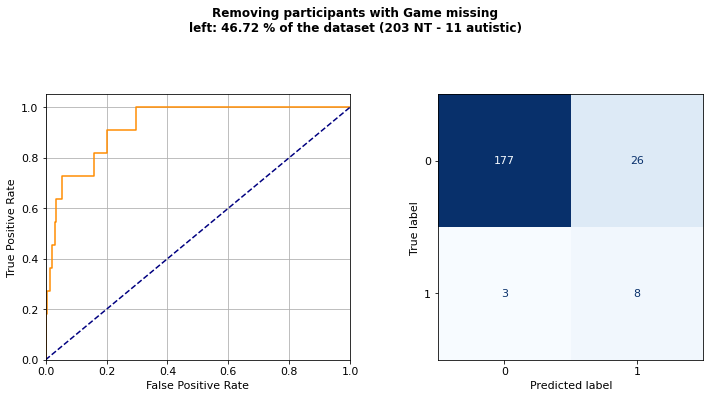

In [386]:

results = deepcopy(exp.performances_df)

results.index = ['All']

for name in ['TP','FN', 'TN', 'FP']:
    results[name] = exp.predictions_df[name].sum()
    
for name in ['TP','FN', 'TN', 'FP']:
    results[name+'_normalized'] = 100*exp.predictions_df[name].mean().round(2)

results['N'] = len(exp.predictions_df)

df_with_none_missing = deepcopy(dataframe.dropna(subset=exp.features_name, how='any'))


for sex, sex_encoding in zip(['Male', 'Female'], [0,1]):
    
    d=dataframe.iloc[list(exp.dataset.df[exp.dataset.df['sex']==sex_encoding].index)]
    
     
    # df with rows having variable missing 
    
    #d = df_with_none_missing.append(dataframe.drop(index=dataframe.dropna(subset=variables, how='any').index))


    title = "Removing participants with {} missing".format(missing)
    title+= "\nleft: {:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(d)/len(dataframe), len(d[d['y_true']==0]), len(d[d['y_true']==1]))
    
    y_true = d['y_true'].to_numpy()
    y_pred = d['y_pred'].to_numpy()
    
    
    

    res = compute_results(d, y_true, y_pred, exp.optimal_threshold, name=sex, title=title)
    
    results = results.append(res)
    
    
    
   



In [398]:
results#['AUROC'].reset_index()

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,FN,TN,FP,TP_normalized,FN_normalized,TN_normalized,FP_normalized,N
All,0.873,0.430,0.872,0.187,0.967,0.482,0.217,0.841,0.443,0.756,0.850,0.354,0.970,0.244,0.646,0.030,34,11,351,62,7.000000,2.000000,77.000000,14.000000,458
All,0.873,0.430,0.872,0.187,0.967,0.482,0.217,0.841,0.443,0.756,0.850,0.354,0.970,0.244,0.646,0.030,34,11,351,62,7.423581,2.401747,76.637555,13.537118,458
None,0.899,0.503,0.970,0.327,0.990,0.485,0.344,0.865,0.463,0.846,0.866,0.314,0.987,0.154,0.686,0.013,11,2,155,24,5.729167,1.041667,80.729167,12.500000,192
Gaze_PR,0.896,0.477,0.891,0.218,0.973,0.542,0.264,0.871,0.501,0.780,0.880,0.405,0.975,0.220,0.595,0.025,32,9,346,47,7.373272,2.073733,79.723502,10.829493,434
Gaze_SS,0.895,0.476,0.886,0.214,0.972,0.541,0.259,0.871,0.508,0.786,0.880,0.412,0.975,0.214,0.588,0.025,33,9,346,47,7.586207,2.068966,79.540230,10.804598,435
RTN_f,0.881,0.442,0.876,0.194,0.968,0.500,0.229,0.848,0.461,0.773,0.856,0.366,0.972,0.227,0.634,0.028,34,10,351,59,7.488987,2.202643,77.312775,12.995595,454
RTN_d,0.877,0.478,0.932,0.257,0.984,0.486,0.274,0.848,0.418,0.710,0.861,0.338,0.967,0.290,0.662,0.033,22,9,267,43,6.451613,2.639296,78.299120,12.609971,341
S_PS,0.895,0.475,0.886,0.213,0.972,0.537,0.259,0.869,0.504,0.786,0.878,0.407,0.975,0.214,0.593,0.025,33,9,346,48,7.568807,2.064220,79.357798,11.009174,436
NS_PS,0.873,0.430,0.872,0.187,0.967,0.482,0.217,0.841,0.443,0.756,0.850,0.354,0.970,0.244,0.646,0.030,34,11,351,62,7.423581,2.401747,76.637555,13.537118,458
S_PSd,0.895,0.475,0.886,0.213,0.972,0.537,0.259,0.869,0.504,0.786,0.878,0.407,0.975,0.214,0.593,0.025,33,9,346,48,7.568807,2.064220,79.357798,11.009174,436


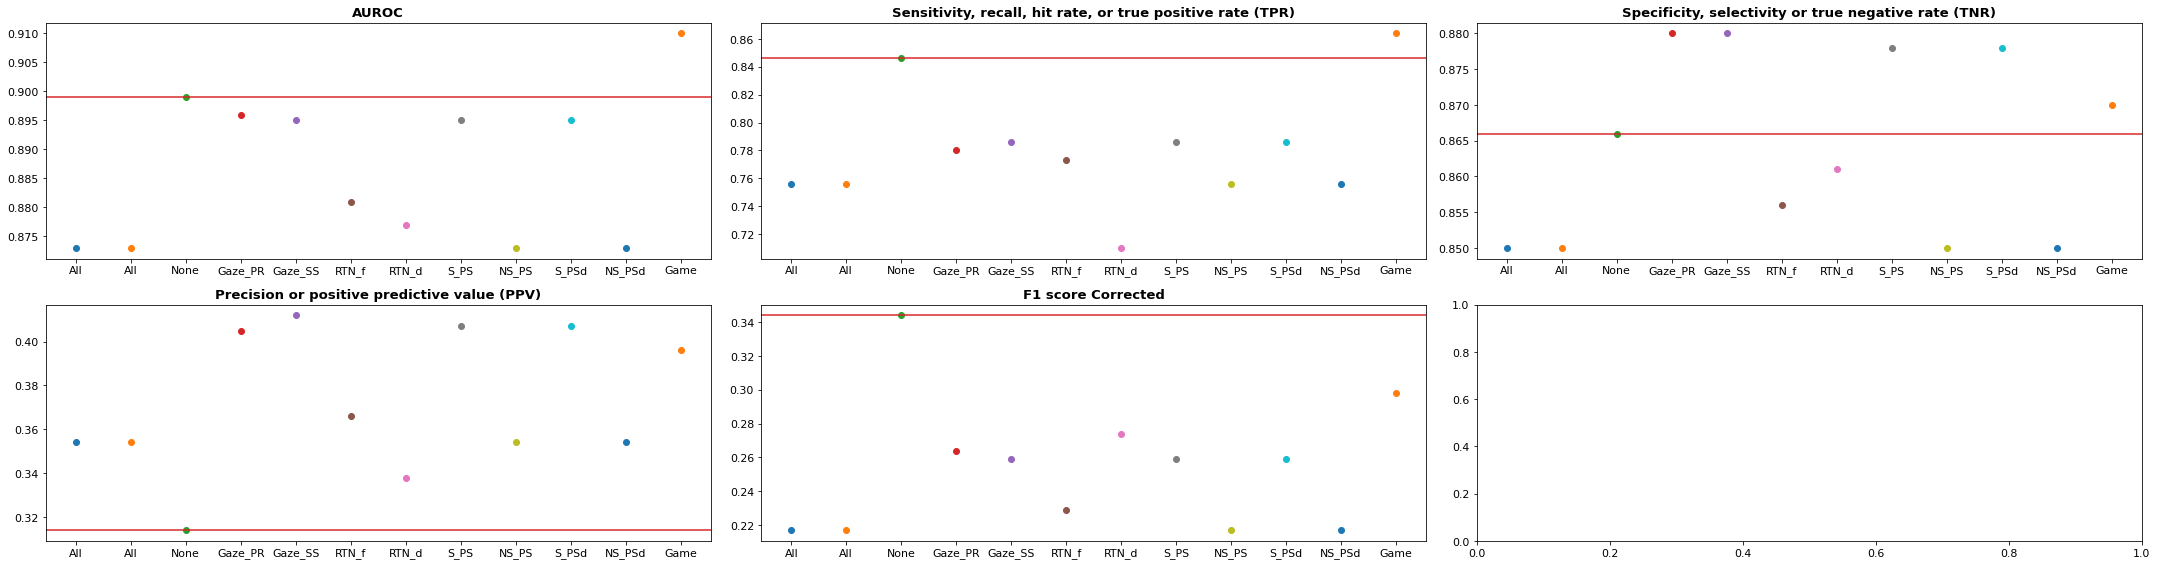

In [404]:
measures = ['AUROC', 'Sensitivity, recall, hit rate, or true positive rate (TPR)', 'Specificity, selectivity or true negative rate (TNR)', 'Precision or positive predictive value (PPV)', 'F1 score Corrected']


n_plots = len(measures)

fix, axes = plt.subplots(3, 2, figsize=(30, 8));axes = axes.flatten()

for idx, measure in enumerate(measures):
    
    #results[measure].plot(kind='bar', ax=axes[idx])
    
    
    for ii, (_, row) in enumerate(results[measure].reset_index().iterrows()):
        
        axes[idx].scatter(ii, row[measure], label=row['index'])
    
    axes[idx].set_xticks(np.arange(len(results)))
    axes[idx].set_xticklabels(results.index)
        
    axes[idx].axhline(results.loc['None', measure], color='tab:red')
        
        
    #axes[idx].legend()
    axes[idx].set_title(measure, weight='bold')
    
plt.tight_layout()

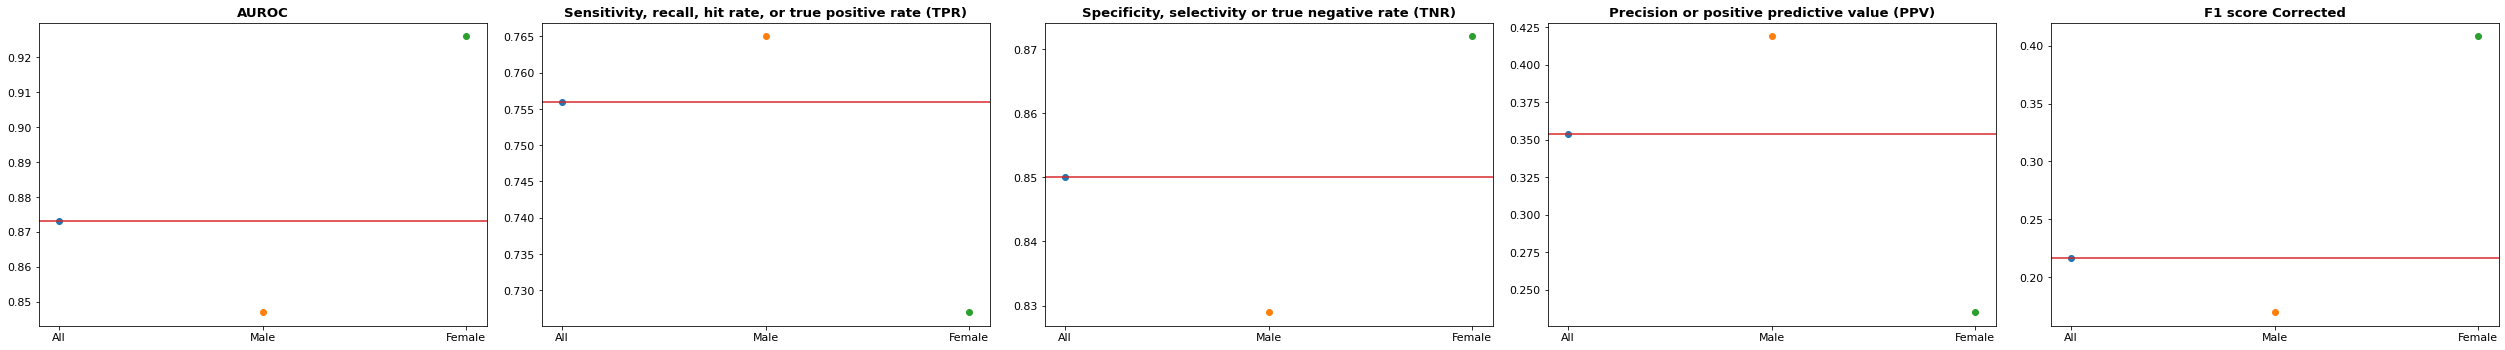

In [396]:
measures = ['AUROC', 'Sensitivity, recall, hit rate, or true positive rate (TPR)', 'Specificity, selectivity or true negative rate (TNR)', 'Precision or positive predictive value (PPV)', 'F1 score Corrected']


n_plots = len(measures)

fix, axes = plt.subplots(1, 5, figsize=(35, 5))#;axes = axes.flatten()

for idx, measure in enumerate(measures):
    
    #results[measure].plot(kind='bar', ax=axes[idx])
    
    
    for ii, (_, row) in enumerate(results[measure].reset_index().iterrows()):
        
        axes[idx].scatter(ii, row[measure], label=row['index'])
    
    axes[idx].set_xticks(np.arange(len(results)))
    axes[idx].set_xticklabels(results.index)
        
    axes[idx].axhline(results.loc['All', measure], color='tab:red')
        
        
    #axes[idx].legend()
    axes[idx].set_title(measure, weight='bold')
    
plt.tight_layout()

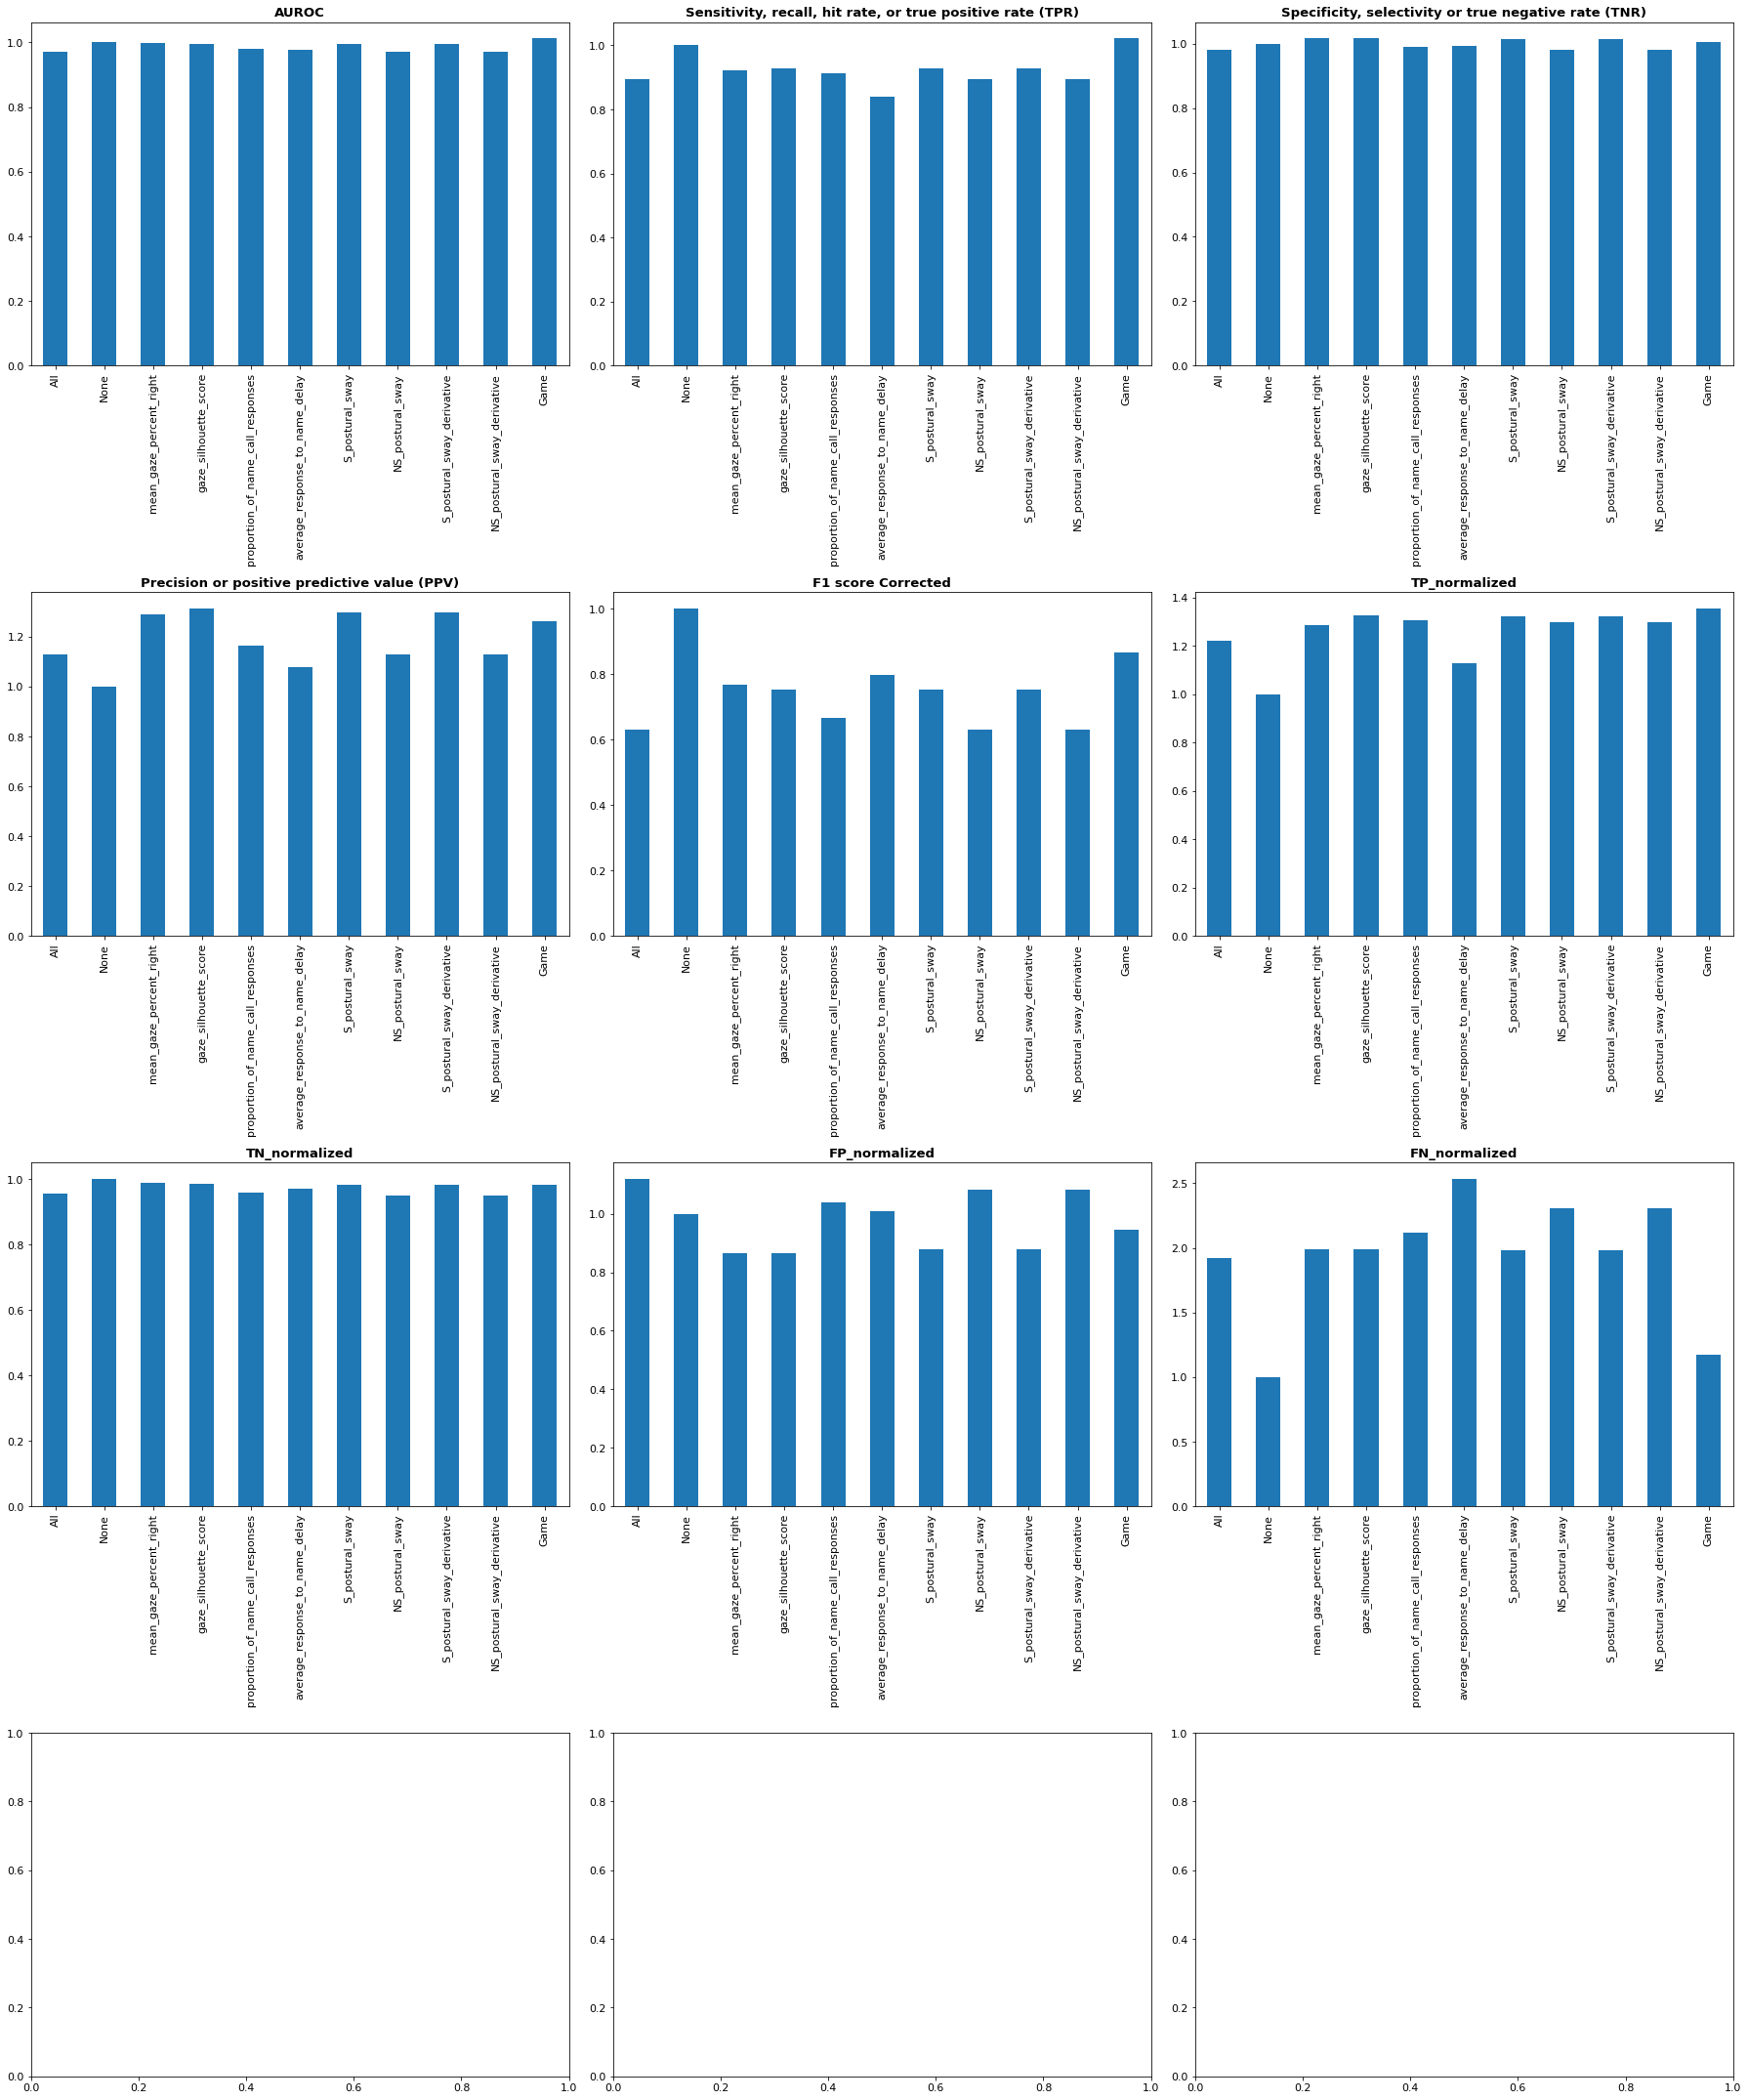

In [291]:
measures = ['AUROC', 'Sensitivity, recall, hit rate, or true positive rate (TPR)', 'Specificity, selectivity or true negative rate (TNR)', 'Precision or positive predictive value (PPV)', 'F1 score Corrected', 
           'TP_normalized', 'TN_normalized', 'FP_normalized', 'FN_normalized']


n_plots = len(measures)

fix, axes = plt.subplots(n_plots//3+1, 3, figsize=(25, 30));axes = axes.flatten()

for idx, measure in enumerate(measures):
    
    results[measure].plot(kind='bar', ax=axes[idx])
    
    axes[idx].set_title(measure, weight='bold')
    
plt.tight_layout()

In [ ]:
    
for idx, (name, row) in enumerate(results.iterrows()):
    
    axes[i].plot(row[measure
    
    
    
    

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
None,0.858,0.425,0.816,0.156,0.931,0.5,0.201,0.823,0.431,0.719,0.838,0.377,0.956,0.281,0.623,0.044,196,23,38,9,0.736842,0.086466,0.142857,0.033835,266


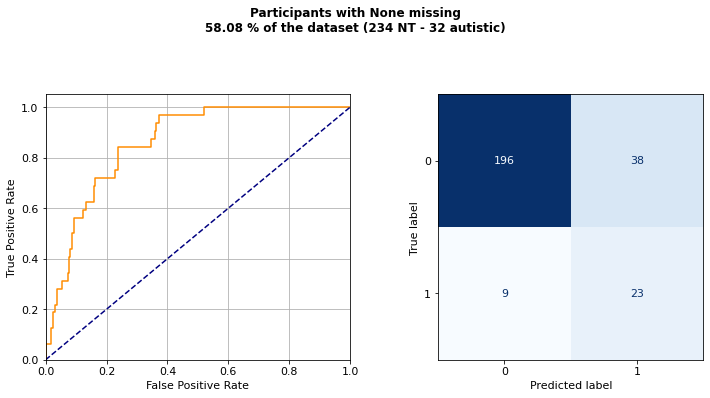

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
average_response_to_name_delay,0.847,0.337,0.701,0.081,0.74,0.533,0.175,0.821,0.495,0.857,0.816,0.387,0.977,0.143,0.613,0.023,84,12,19,2,0.717949,0.102564,0.162393,0.017094,117


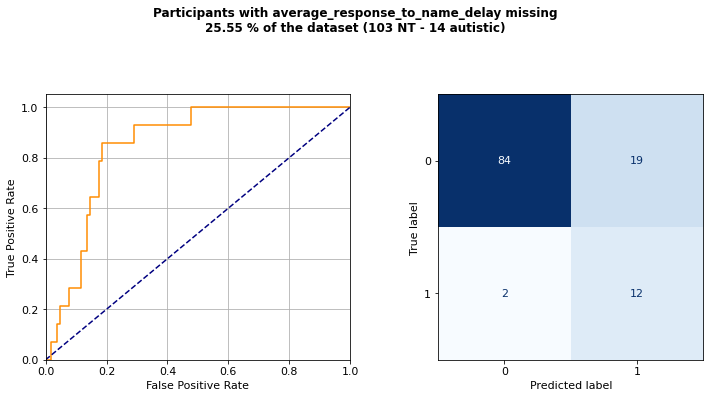

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TN,TP,FP,FN,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N
Game,0.828,0.385,0.807,0.168,0.954,0.423,0.195,0.808,0.355,0.652,0.826,0.312,0.952,0.348,0.688,0.048,157,15,33,8,0.737089,0.070423,0.15493,0.037559,213


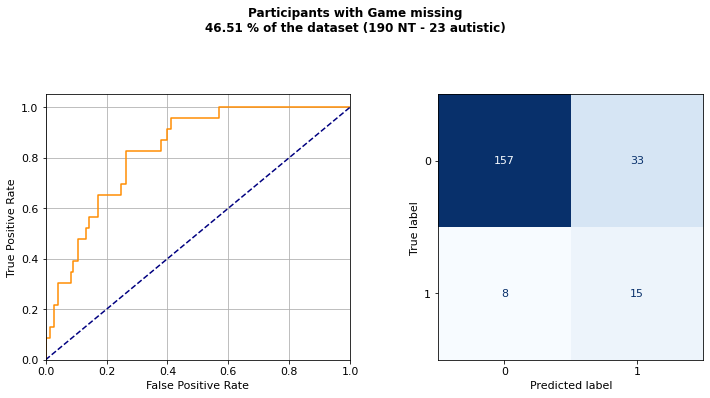

In [250]:
from metrics import f1score, average_precision, bestf1score, calc_auprg, create_prg_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, plot_roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score
import prg


mapping_name = {0: "Complete", 
                12: "Only game missing", 
                1: "Only delay missing", 
                13: "Game & Delay missing"}

#for mdp_index in mapping_name.keys():
#    d = dataframe[dataframe['mdp']==mdp_index]

grouped_missing_features = {'All': [], 
                            'None':DEFAULT_PREDICTORS,
                            'mean_gaze_percent_right': ['mean_gaze_percent_right'],
                             'gaze_silhouette_score': ['gaze_silhouette_score'],
                             'proportion_of_name_call_responses': ['proportion_of_name_call_responses'],
                             'average_response_to_name_delay': ['average_response_to_name_delay'],
                            
                             'S_postural_sway': ['S_postural_sway'],
                             'NS_postural_sway': ['NS_postural_sway'],
                             'S_postural_sway': ['S_postural_sway'],
                             'S_postural_sway_derivative': ['S_postural_sway_derivative'],
                             'NS_postural_sway_derivative': ['NS_postural_sway_derivative'],
                             'Game': ['average_length','std_length','average_error', 'pop_rate','average_delay_to_pop','average_time_spent'], 
                             }

results = deepcopy(exp.performances_df)

results.index = ['All']

for name in ['TP','FN', 'TN', 'FP']:
    results[name] = exp.predictions_df[name].sum()
    
for name in ['TP','FN', 'TN', 'FP']:
    results[name+'_normalized'] = 100*exp.predictions_df[name].mean().round(2)

results['N'] = len(exp.predictions_df)



for missing, variables in grouped_missing_features.items():
    
    d=dataframe.drop(index=dataframe.dropna(subset=variables, how='any').index)
    if len(d) <50:
        continue

    
    title = "Participants with {} missing".format(missing)
    title+= "\n{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(d)/len(dataframe), len(d[d['y_true']==0]), len(d[d['y_true']==1]))
    
    y_true = d['y_true'].to_numpy()
    y_pred = d['y_pred'].to_numpy()
    
    
    

    res = compute_results(d, y_true, y_pred, exp.optimal_threshold, name=missing, title=title)
    
    results = results.append(res)
    
    

In [259]:
results

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TP_normalized,FN,FN_normalized,TN,TN_normalized,FP,FP_normalized,N
All,0.873,0.430,0.872,0.187,0.967,0.482,0.217,0.841,0.443,0.756,0.850,0.354,0.970,0.244,0.646,0.030,34,7.000000,11,2.000000,351,77.000000,62,14.000000,458
None,0.858,0.425,0.816,0.156,0.931,0.500,0.201,0.823,0.431,0.719,0.838,0.377,0.956,0.281,0.623,0.044,23,0.086466,9,0.033835,196,0.736842,38,0.142857,266
average_response_to_name_delay,0.847,0.337,0.701,0.081,0.740,0.533,0.175,0.821,0.495,0.857,0.816,0.387,0.977,0.143,0.613,0.023,12,0.102564,2,0.017094,84,0.717949,19,0.162393,117
Game,0.828,0.385,0.807,0.168,0.954,0.423,0.195,0.808,0.355,0.652,0.826,0.312,0.952,0.348,0.688,0.048,15,0.070423,8,0.037559,157,0.737089,33,0.154930,213


Text(0, 0.5, 'True Positive Rate')

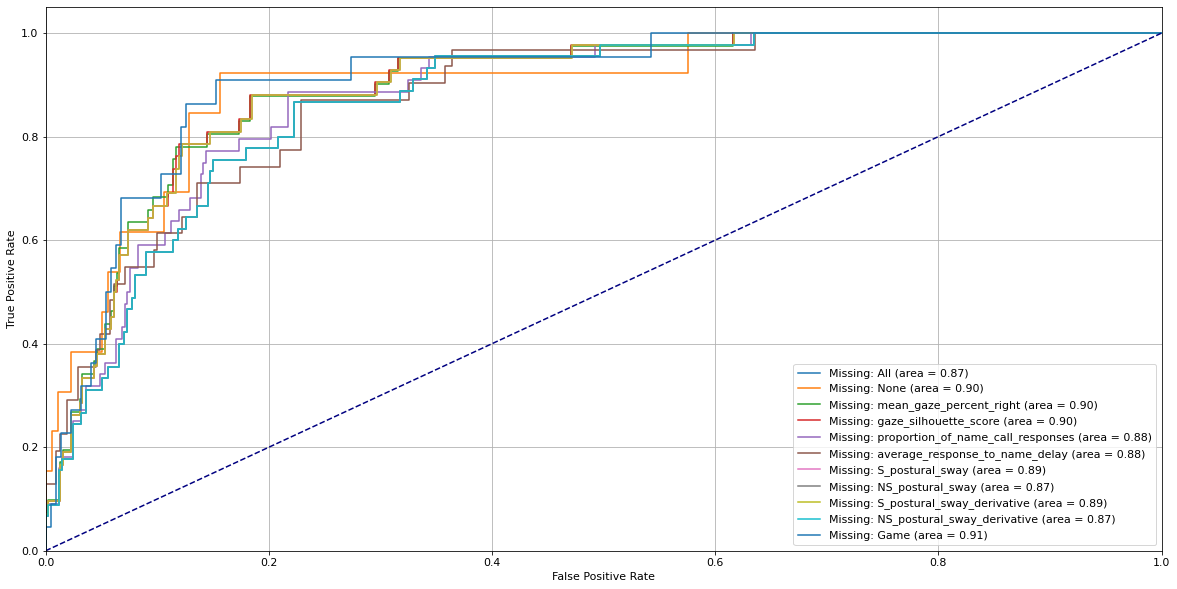

In [240]:
fig, ax =  plt.subplots(1, 1, figsize=(20, 10))


for missing, variables in grouped_missing_features.items():
    
    d=dataframe.dropna(subset=variables, how='any') 

    
    title = missing
    y_true = d['y_true'].to_numpy()
    y_pred = d['y_pred'].to_numpy()
    
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, '-', lw=1.5, label='Missing: {} (area = {:.2f})'.format(missing, roc_auc))


ax.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
ax.legend()
ax.set_xlim([0.0, 1.0]); ax.set_ylim([0.0, 1.05]); ax.grid()
ax.set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')

In [243]:
results

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TP_normalized,FN,FN_normalized,TN,TN_normalized,FP,FP_normalized,N
All,0.873,0.430,0.872,0.187,0.967,0.482,0.217,0.841,0.443,0.756,0.850,0.354,0.970,0.244,0.646,0.030,34,7.000000,11,2.000000,351,77.000000,62,14.000000,458
All,0.873,0.430,0.872,0.187,0.967,0.482,0.217,0.841,0.443,0.756,0.850,0.354,0.970,0.244,0.646,0.030,34,0.074236,11,0.024017,351,0.766376,62,0.135371,458
None,0.899,0.503,0.970,0.327,0.990,0.485,0.344,0.865,0.463,0.846,0.866,0.314,0.987,0.154,0.686,0.013,11,0.057292,2,0.010417,155,0.807292,24,0.125000,192
mean_gaze_percent_right,0.896,0.477,0.891,0.218,0.973,0.542,0.264,0.871,0.501,0.780,0.880,0.405,0.975,0.220,0.595,0.025,32,0.073733,9,0.020737,346,0.797235,47,0.108295,434
gaze_silhouette_score,0.895,0.476,0.886,0.214,0.972,0.541,0.259,0.871,0.508,0.786,0.880,0.412,0.975,0.214,0.588,0.025,33,0.075862,9,0.020690,346,0.795402,47,0.108046,435
proportion_of_name_call_responses,0.881,0.442,0.876,0.194,0.968,0.500,0.229,0.848,0.461,0.773,0.856,0.366,0.972,0.227,0.634,0.028,34,0.074890,10,0.022026,351,0.773128,59,0.129956,454
average_response_to_name_delay,0.877,0.478,0.932,0.257,0.984,0.486,0.274,0.848,0.418,0.710,0.861,0.338,0.967,0.290,0.662,0.033,22,0.064516,9,0.026393,267,0.782991,43,0.126100,341
S_postural_sway,0.895,0.475,0.886,0.213,0.972,0.537,0.259,0.869,0.504,0.786,0.878,0.407,0.975,0.214,0.593,0.025,33,0.075688,9,0.020642,346,0.793578,48,0.110092,436
NS_postural_sway,0.873,0.430,0.872,0.187,0.967,0.482,0.217,0.841,0.443,0.756,0.850,0.354,0.970,0.244,0.646,0.030,34,0.074236,11,0.024017,351,0.766376,62,0.135371,458
S_postural_sway_derivative,0.895,0.475,0.886,0.213,0.972,0.537,0.259,0.869,0.504,0.786,0.878,0.407,0.975,0.214,0.593,0.025,33,0.075688,9,0.020642,346,0.793578,48,0.110092,436


In [317]:
grouped_missing_features = {'None':DEFAULT_PREDICTORS,
                            'mean_gaze_percent_right': ['mean_gaze_percent_right'],
                             'gaze_silhouette_score': ['gaze_silhouette_score'],
                             'proportion_of_name_call_responses': ['proportion_of_name_call_responses'],
                             'average_response_to_name_delay': ['average_response_to_name_delay'],
                            
                             'S_postural_sway': ['S_postural_sway'],
                             'NS_postural_sway': ['NS_postural_sway'],
                             'S_postural_sway': ['S_postural_sway'],
                             'S_postural_sway_derivative': ['S_postural_sway_derivative'],
                             'NS_postural_sway_derivative': ['NS_postural_sway_derivative'],
                             'Game': ['average_length','std_length','average_error', 'pop_rate','average_delay_to_pop','average_time_spent'], 
                             }


for missing, variables in grouped_missing_features.items():
    
    d=dataframe.drop(index=dataframe.dropna(subset=variables, how='any').index)
    print(missing, len(d)/len(dataframe))

    

None 0.5835140997830802
mean_gaze_percent_right 0.052060737527114966
gaze_silhouette_score 0.049891540130151846
proportion_of_name_call_responses 0.008676789587852495
average_response_to_name_delay 0.25813449023861174
S_postural_sway 0.04772234273318872
NS_postural_sway 0.0
S_postural_sway_derivative 0.04772234273318872
NS_postural_sway_derivative 0.0
Game 0.4685466377440347


In [313]:
dataframe

,mean_gaze_percent_right,gaze_silhouette_score,proportion_of_name_call_responses,average_response_to_name_delay,S_postural_sway,NS_postural_sway,S_postural_sway_derivative,NS_postural_sway_derivative,average_length,std_length,average_error,pop_rate,average_delay_to_pop,average_time_spent,Z_FunAtThePark,Z_RhymesAndToys,Z_RTNDelay,y_true,y_pred,TN,TP,FP,FN,mdp
0,0.326988,0.777235,0.000000,NaN,0.176733,0.326318,0.000278,0.001556,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.191201,1,0,0,0,13
1,0.481269,0.582087,1.000000,1.384717,0.205969,1.238350,0.000476,0.013931,7.781981,6.760262,11.703175,0.800000,2.695000,0.7410,0.0,0.0,0.0,0.0,0.186685,1,0,0,0,0
2,0.587493,0.696044,0.333333,1.434767,0.143356,1.029170,0.000298,0.010124,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.248617,1,0,0,0,12
3,0.434169,0.393004,1.000000,0.556111,2.978287,2.007431,0.016263,0.006172,6.856880,8.420087,11.981659,0.888889,3.211286,0.9270,0.0,0.0,0.0,0.0,0.427092,0,0,1,0,0
4,0.423279,0.648212,0.000000,NaN,0.459610,1.223822,0.002618,0.009418,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.205934,1,0,0,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,0.541262,0.631822,0.000000,NaN,0.395346,0.410796,0.001360,0.001786,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.208426,1,0,0,0,13
457,0.351852,0.363444,0.000000,NaN,15.525090,2.049878,0.043511,0.011376,0.287249,0.685069,47.376278,0.036364,1.320000,0.3596,1.0,0.0,1.0,1.0,0.511246,0,1,0,0,1
458,0.819843,0.516762,1.000000,0.767433,6.912055,5.887994,0.028985,0.032651,0.563128,0.974058,4.969821,1.000000,3.705667,NaN,0.0,0.0,0.0,1.0,0.520608,0,1,0,0,3
459,0.381880,0.452298,0.000000,NaN,2.839317,0.858109,0.015335,0.004834,14.188632,19.856556,10.427951,0.888889,3.014625,NaN,0.0,0.0,1.0,1.0,0.426379,0,1,0,0,5


## Explain the model's predictions on the entire dataset¶


In [132]:
import shap 
X, y = data.df[DEFAULT_PREDICTORS+ ['Z_FunAtThePark', 'Z_RhymesAndToys']], data.y_train



explainer = shap.TreeExplainer(exp.model, feature_names=exp.features_name)
shap_values = explainer.shap_values(X, approximate=False)

## SHAP Summary Plot¶


The SHAP values for XGBoost explain the margin output of the model, which is the change in log odds of being autistic for the trained XGBoost model. 

This summary plot replaces the typical bar chart of feature importance. It tells which features are most important, and also their range of effects over the dataset. The color allows us match how changes in the value of a feature effect the change in risk.

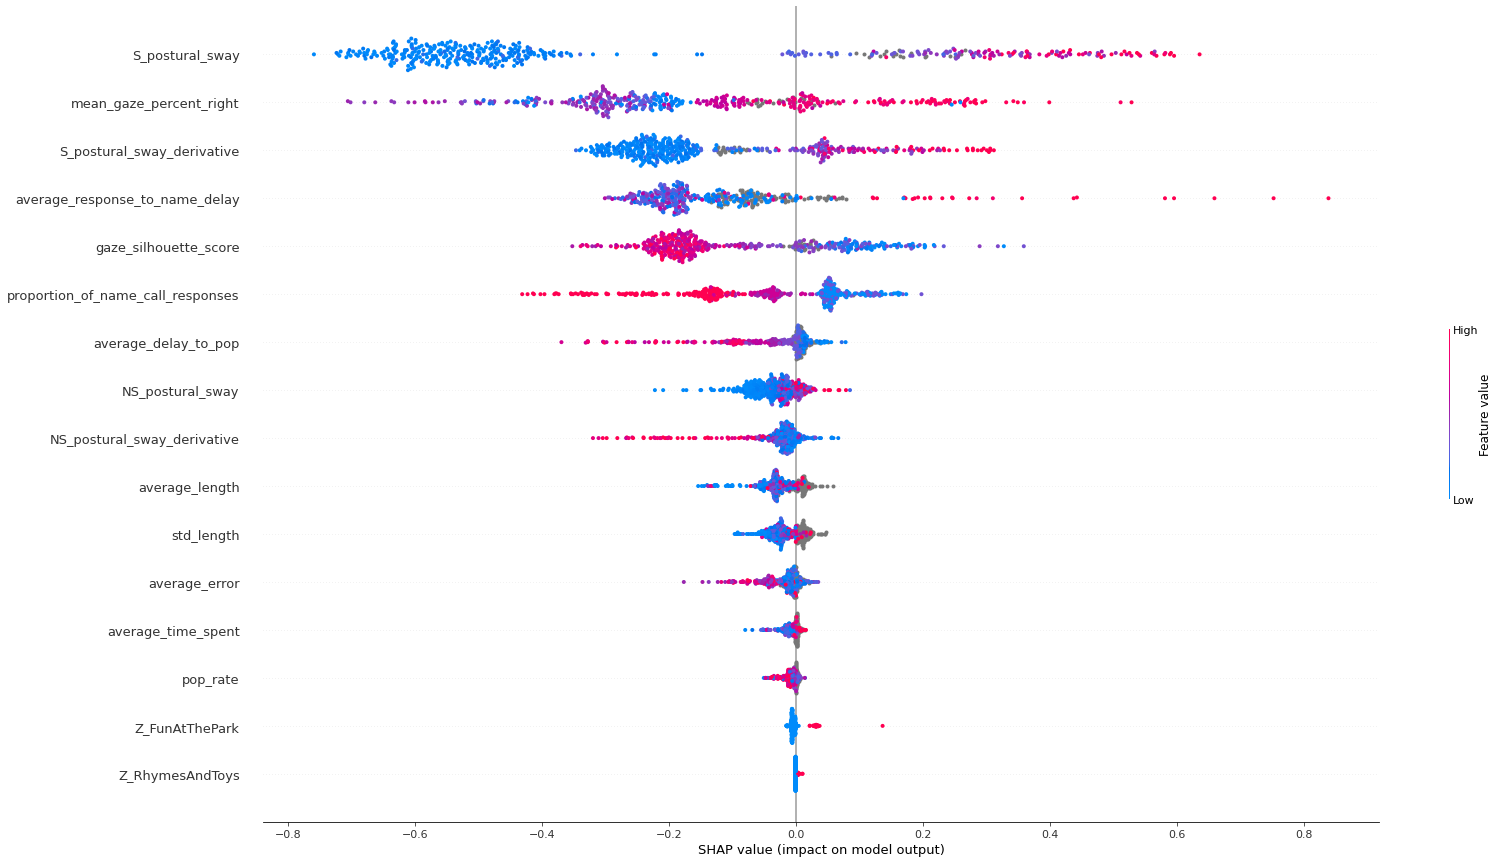

In [133]:
shap.summary_plot(shap_values, X, feature_names=DEFAULT_PREDICTORS+ ['Z_FunAtThePark', 'Z_RhymesAndToys'], plot_size=(25, 15))

## SHAP Dependence Plots


While a SHAP summary plot gives a general overview of each feature a SHAP dependence plot show how the model output varies by feauture value. Note that every dot is a participant, and the vertical dispersion at a single feature value results from interaction effects in the model. The feature used for coloring is automatically chosen to highlight what might be driving these interactions. Later we will see how to check that the interaction is really in the model with SHAP interaction values. Note that the row of a SHAP summary plot results from projecting the points of a SHAP dependence plot onto the y-axis, then recoloring by the feature itself.


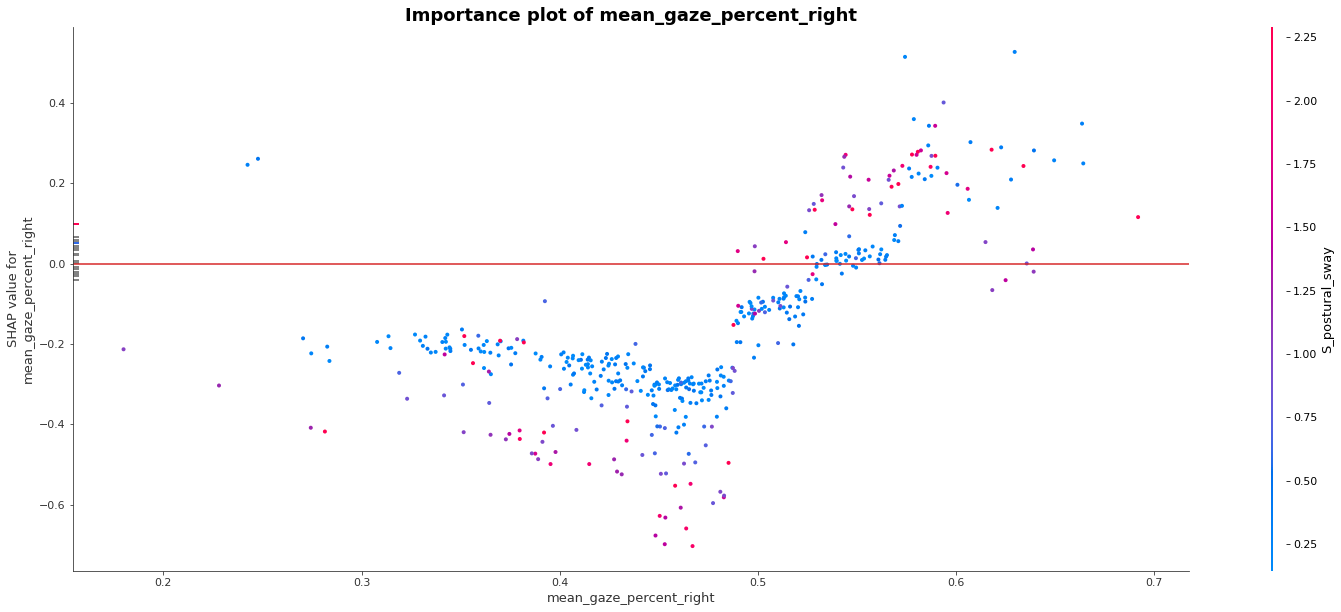

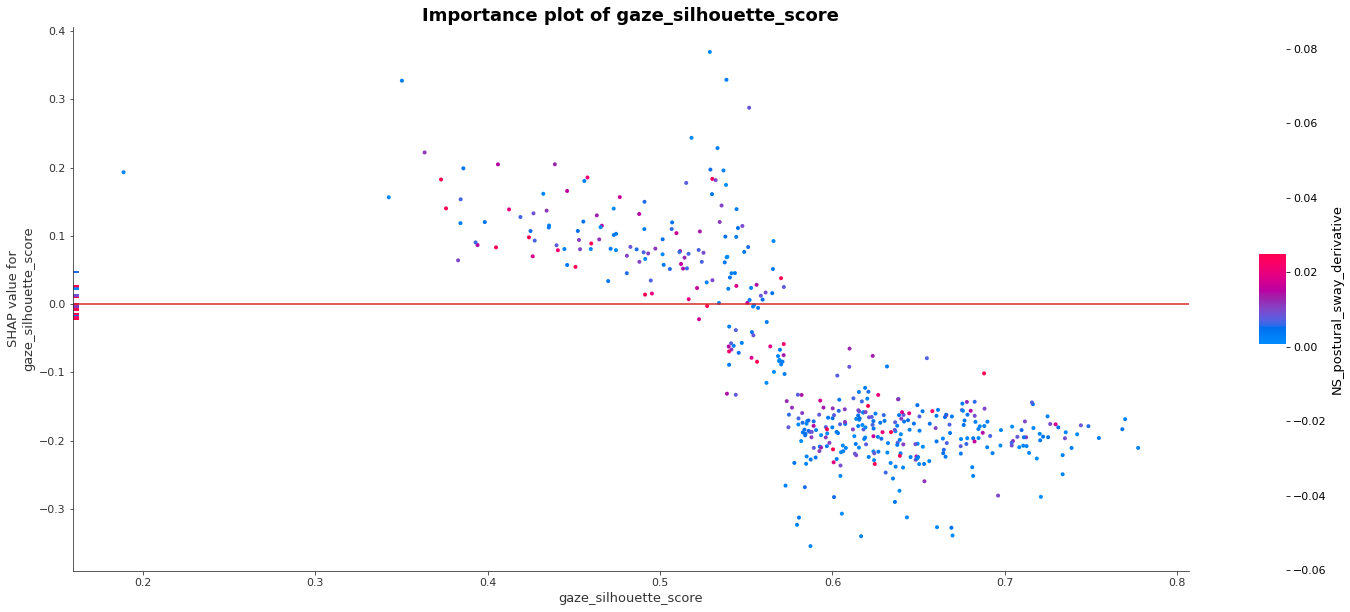

ValueError: Passing parameters norm and vmin/vmax simultaneously is not supported. Please pass vmin/vmax directly to the norm when creating it.

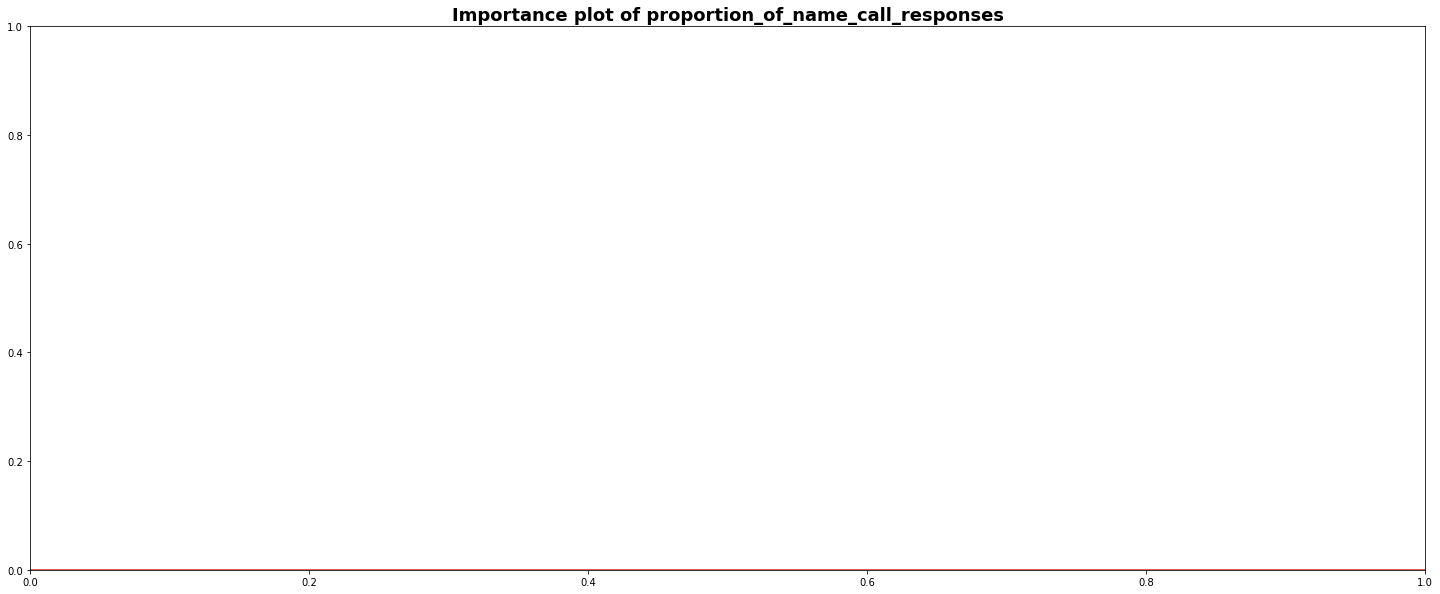

In [298]:


for feat in DEFAULT_PREDICTORS:
    if feat =='NS_postural_sway':
        continue
    
    fig = plt.figure(figsize=(25, 10));ax=plt.gca()
    ax.axhline(0, color='tab:red')
    ax.set_title("Importance plot of {}".format(feat), weight='bold', fontsize=18)
    shap.dependence_plot(feat, shap_values, X,ax=ax)


In [5]:
from xgboost import XGBClassifier, plot_importance, plot_tree
XGBClassifier(use_label_encoder=False, # TODO ADD PLAYING WITH PARAMETERS 
                                      learning_rate=0.01,
                                       n_estimators= 100,
                                      max_depth = 6,
                                      verbosity=3,
                                      objective='binary:logistic',
                                      eval_metric='auc',
                                      booster='gbtree',
                                      #enable_categorical=True, 
                                      tree_method='exact',
                                      subsample=.8,
              colsample_bytree
                                      colsample_bylevel=.8,
                                      alpha=0)

XGBClassifier(alpha=0, base_score=None, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eval_metric='auc', gamma=None,
              gpu_id=None, importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_delta_step=None, max_depth=6,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=None, ...)

In [2]:
XGBClassifier(gpu_id=0)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=0,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)